In [6]:
import numpy as np
from scipy.linalg import expm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import functions as fn
from scipy.linalg import logm, norm, eig
import pandas as pd

# np.set_printoptions(precision=2, suppress=True)

# # Generator for 4-site ring Markov chain
# ε = .25 # chirality parameter
# L = np.array([
#     [-2, 1 + ε, 0, 1 - ε],
#     [1 - ε, -2, 1 + ε, 0],
#     [0, 1 - ε, -2, 1 + ε],
#     [1 + ε, 0, 1 - ε, -2]
# ])

# t = np.exp(2*np.pi * 1j / 4)  # rotation factor for the eigenvectors
# r1, r2, r3, r4 = [np.array([1, t**(mu), t**(2*mu), t**(3*mu)]) / 2 for mu in [0, 1, 3, 2]]
# l1, l2, l3, l4 = 0, -2 + 2j * ε, -2 - 2j * ε, -4

# # assert that the evals and evecs are correct with the eval equation
# for i, (l, r) in enumerate(zip([l1, l2, l3, l4], [r1, r2, r3, r4])):
#     print(L.shape, r.shape)
#     assert np.allclose(l * r, L @ r), f"Eigenvalue {i} does not satisfy the eigenvalue equation: {l} * {r} != {L @ r}"

# p1 = r1/2 + r4/2
# p2 = r1/2 + r2/4 + r3/4

# print(f"p1: {p1},\np2: {p2}")
# # Check that p1, p2 are valid probability distributions (real, non-negative, sum to 1)
# for name, p in zip(['p1', 'p2'], [p1, p2]):
#     assert np.allclose(p.imag, 0), f"{name} has non-zero imaginary part"
#     assert np.isclose(np.sum(p.real), 1), f"{name} does not sum to one: {np.sum(p.real)}"
#     assert (p.real >= 0).all(), f"{name} has negative entries: {p.real}"

    
# # Symmetry measure
# def M(p):
#     p = np.real_if_close(p)        # remove tiny imag parts
#     p = np.clip(p, 1e-16, None)    # floor to avoid log of zero/negatives
#     return np.sum(p * np.log(4 * p))

# # Time grid
# t = np.linspace(0, 1, 300)

# # Numerical M
# M1_num = [M(expm(L * ti).dot(p1)) for ti in t]
# M2_num = [M(expm(L * ti).dot(p2)) for ti in t]

# # Analytical time evolution
# p1_ana = np.array([(r1 + np.exp(l4 * ti) * r4) / 2 for ti in t])
# p2_ana = np.array([(r1 + np.exp(l2 * ti) * r2 / 2 + np.exp(l3 * ti) * r3 / 2) / 2 for ti in t])
# M1_ana = np.array([np.exp(-8 * ti) for ti in t])/2 #[M(p) for p in p1_ana]
# M2_ana = np.array([np.exp(-4 * ti) for ti in t])/4 #[[M(p) for p in p2_ana]

# # Plot
# plt.figure()
# plt.plot(t, M1_num, label=r'$M(p_1(t))$ (numeric)', color='C0')
# plt.plot(t, M2_num, label=r'$M(p_2(t))$ (numeric)', color='C1')

# # Find the crossing point between M1_num and M2_num

# diff = np.array(M1_num) - np.array(M2_num)
# sign_change = np.where(np.diff(np.sign(diff)))[0]
# if len(sign_change) > 0:
#     i = sign_change[0]
#     f = interp1d(diff[i:i+2], t[i:i+2])
#     t_cross = float(f(0))
#     plt.axvline(t_cross, color='k', linestyle='-.', label=fr'$t_{{\rm cross}}={t_cross:.3f}$')
# else:
#     t_cross = None


# plt.plot(t, M1_ana, ls='--', label=r'$e^{-4t}/4$ (asymptotic)', c='C0', lw = 5, alpha=0.4)
# plt.plot(t, M2_ana, ls='--', label=r'$e^{-8t}/2$ (asymptotic)', c='C1', lw = 5, alpha=0.4)
# plt.axvline(np.log(2)/4, ls=':', label=r'$\tau=\ln(2)/4$', c='k')
# plt.xlabel('t')
# plt.ylabel(r'$M(p(t))$')
# plt.title('Symmetry Mpemba with classical Markov chain')
# plt.yscale('log')
# plt.legend()
# plt.tight_layout()
# plt.show()


In [7]:
# # Define node positions on a square
# positions = np.array([
#     [0, 0],  # site 0
#     [1, 0],  # site 1
#     [1, 1],  # site 2
#     [0, 1]   # site 3
# ])

# # Initial distributions (normalized)
# r0 = np.array([1, 1, 1, 1]) / 4
# r1 = np.array([1, 1j, -1, -1j]) / 4
# r2 = np.array([1, -1, 1, -1]) / 4
# r3 = np.array([1, -1j, -1, 1j]) / 4
# p1 = (r0 + r1 - r3).real
# p2 = (r0 + r2).real

# # Plot settings
# fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# for ax, p, title in zip(axes, [p1, p2], ['Initial $p_1$', 'Initial $p_2$']):
#     # Draw square edges
#     square = np.vstack([positions, positions[0]])
#     ax.plot(square[:, 0], square[:, 1], linestyle='-', linewidth=1)
    
#     # Scatter nodes with size proportional to probability
#     sizes = 300 * p
#     ax.scatter(positions[:, 0], positions[:, 1], s=sizes)
    
#     # Label nodes
#     for idx, (x, y) in enumerate(positions):
#         ax.text(x, y, f'{idx}', ha='center', va='center', color='white', fontsize=12)
    
#     ax.set_aspect('equal')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_title(title)

# plt.tight_layout()
# plt.show()


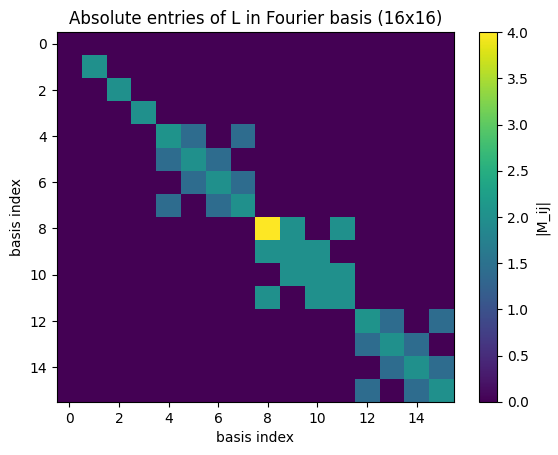

Max off-diagonal magnitude: 1.17e-16 (should be ~0)
Min diagonal magnitude:    1.00e+00 (should be ~1)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig, block_diag

# 1) Build the Fourier-twisted basis F_{q,r}
def build_fourier_basis(N=4):
    F_list = []
    for q in range(N):
        for r in range(N):
            # Build F_{q,r} = (1/N) sum_m exp(-2pi i q m / N) E_{m+r, m}
            F = np.zeros((N, N), complex)
            for m in range(N):
                F[(m + r) % N, m] += 2 * np.exp(-2j * np.pi * q * m / N)
            F /= N
            F_list.append(F)
    return F_list

# 2) Vectorize basis and form change-of-basis matrix B
def vec(mat):
    return mat.reshape(-1, order='F')

N = 4
L_q = np.zeros((N*N, N*N), complex)
# Reuse quantum_liouvillian from before
def quantum_liouvillian(epsilon: float, J: float = 1.0):
    ops = [[np.zeros((N, N), complex) for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            ops[i][j][i, j] = 1
    H = np.zeros((N, N), complex)
    for i in range(N):
        H[i, (i + 1) % N] = J
        H[(i + 1) % N, i] = J
    r_plus, r_minus = np.sqrt(1 + epsilon), np.sqrt(1 - epsilon)
    c_ops = [r_plus*ops[(i+1)%N][i] for i in range(N)] + [r_minus*ops[(i-1)%N][i] for i in range(N)]
    Id = np.eye(N, dtype=complex)
    L = -1j*(np.kron(Id, H) - np.kron(H.T, Id))
    for c in c_ops:
        cdc = c.conj().T @ c
        L += np.kron(c.conj(), c) - 0.5*np.kron(Id, cdc) - 0.5*np.kron(cdc.T, Id)
    return L

L_q = quantum_liouvillian(0.25, 1.0)
F_list = build_fourier_basis(N)
B = np.column_stack([vec(F) for F in F_list])

# 3) Change basis: M = B^{-1} L B
B_inv = np.linalg.inv(B)
M = B_inv @ L_q @ B

# 4) Plot heatmap of |M| to show block structure
plt.imshow(np.abs(M), aspect='auto')
plt.colorbar(label='|M_ij|')
plt.title('Absolute entries of L in Fourier basis (16x16)')
plt.xlabel('basis index')
plt.ylabel('basis index')
plt.show()

# Compute Gram matrix G = B^† B
G = B.conj().T @ B

# Check off-diagonal and diagonal entries
max_off = np.max(np.abs(G - np.diag(np.diag(G))))
min_on = np.min(np.abs(np.diag(G)))

print(f"Max off-diagonal magnitude: {max_off:.2e} (should be ~0)")
print(f"Min diagonal magnitude:    {min_on:.2e} (should be ~1)")

In [9]:
F_list = build_fourier_basis(N)
B = np.column_stack([F.reshape(N*N, order='F') for F in F_list])
B_inv = np.linalg.inv(B)
M = B_inv @ L_q @ B

# Extract block for mu = 1
mu = 3
block = M[mu*N:(mu+1)*N, mu*N:(mu+1)*N]
# Create DataFrame for display
df_block = pd.DataFrame(np.round(block, 3),
                        index=[f'alpha={r}' for r in range(N)],
                        columns=[f'alpha\'={r}' for r in range(N)])

df_block

,alpha'=0,alpha'=1,alpha'=2,alpha'=3
alpha=0,-2.0-0.5j,1.0-1.0j,0.0+0.0j,-1.0-1.0j
alpha=1,-1.0-1.0j,-2.0+0.0j,1.0-1.0j,0.0+0.0j
alpha=2,0.0+0.0j,-1.0-1.0j,-2.0+0.0j,1.0-1.0j
alpha=3,1.0-1.0j,0.0+0.0j,-1.0-1.0j,-2.0+0.0j


In [10]:
import numpy as np
import pandas as pd
from scipy.linalg import eig

# 1) Define Liouvillian and Fourier basis
def quantum_liouvillian(epsilon: float, J: float = 1.0, N=4):
    ops = [[np.zeros((N, N), complex) for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            ops[i][j][i, j] = 1
    H = np.zeros((N, N), complex)
    for i in range(N):
        H[i, (i + 1) % N] = J
        H[(i + 1) % N, i] = J
    r_plus, r_minus = np.sqrt(1 + epsilon), np.sqrt(1 - epsilon)
    c_ops = [r_plus*ops[(i+1)%N][i] for i in range(N)] + [r_minus*ops[(i-1)%N][i] for i in range(N)]
    Id = np.eye(N, dtype=complex)
    L = -1j*(np.kron(Id, H) - np.kron(H.T, Id))
    for c in c_ops:
        cdc = c.conj().T @ c
        L += np.kron(c.conj(), c) - 0.5*np.kron(Id, cdc) - 0.5*np.kron(cdc.T, Id)
    return L

def build_fourier_basis(N=4):
    F_list = []
    for mu in range(N):
        for alpha in range(N):
            F = np.zeros((N, N), complex)
            for m in range(N):
                F[(m + alpha) % N, m] += np.exp(-2j * np.pi * mu * m / N)
            F /= N
            F_list.append(F)
    return F_list

# 2) Build L_q and change-of-basis B
N = 4
L_q = quantum_liouvillian(0.25, 1.0, N)
F_list = build_fourier_basis(N)
B = np.column_stack([F.reshape(N*N, order='F') for F in F_list])
B_inv = np.linalg.inv(B)
M = B_inv @ L_q @ B

# 3) Diagonalize each block M_mu of size 4x4
results = []
dic = {}
for mu in range(N):
    block = M[mu*N:(mu+1)*N, mu*N:(mu+1)*N]
    vals, vecs = eig(block)
    for k in range(N):
        coeffs = vecs[:, k]
        results.append({
            'μ': mu,
            'k': k,
            'eigenvalue': np.round(vals[k], 8),
            'coeffs': [np.round(c, 4) for c in coeffs]
        })
        
        if mu not in dic:
            dic[(mu,k)] = []
        dic[(mu,k)].append({
            'eigenvalue': np.round(vals[k], 8),
            'coeffs': [np.round(c, 4) for c in coeffs]
        })

# 4) Present in DataFrame
df = pd.DataFrame(results)
import ace_tools_open as tools; tools.display_dataframe_to_user("Eigen-decomposition per Z4 sector", df)


Eigen-decomposition per Z4 sector


Loading ITables v2.4.2 from the internet... (need help?)


In [11]:
# Block-diagonalize and test
max_resid = 0.0
resids = []
evecs_dic, evals_dic = {}, {}
for mu in range(4):
    # 1) extract the true similarity-transformed block
    M_mu = B_inv @ L_q @ B
    block = M_mu[mu*4:(mu+1)*4, mu*4:(mu+1)*4]

    # 2) diagonalize
    vals, vecs = eig(block)

    # 3) lift each eigenvector back to the full space and check
    for k in range(4):
        λ = vals[k]
        v = vecs[:, k]
        c = np.zeros(16, complex)
        c[mu*4:(mu+1)*4] = v
        ψ = B @ c
        resid = L_q @ ψ - λ * ψ
        evecs_dic[(mu, k)] = ψ
        evals_dic[(mu, k)] = λ
        resids.append({
            'mu': mu,
            'k': k,
            'λ': np.round(λ, 2),
            'residual_norm': np.linalg.norm(resid)
        })
        max_resid = max(max_resid, np.linalg.norm(resid))

print(f"Maximum residual norm: {max_resid:.2e}")
df_resids = pd.DataFrame(resids)
import ace_tools_open as tools; tools.display_dataframe_to_user("Residuals of eigenvalue equation", df_resids)


Maximum residual norm: 1.52e-15
Residuals of eigenvalue equation


Loading ITables v2.4.2 from the internet... (need help?)


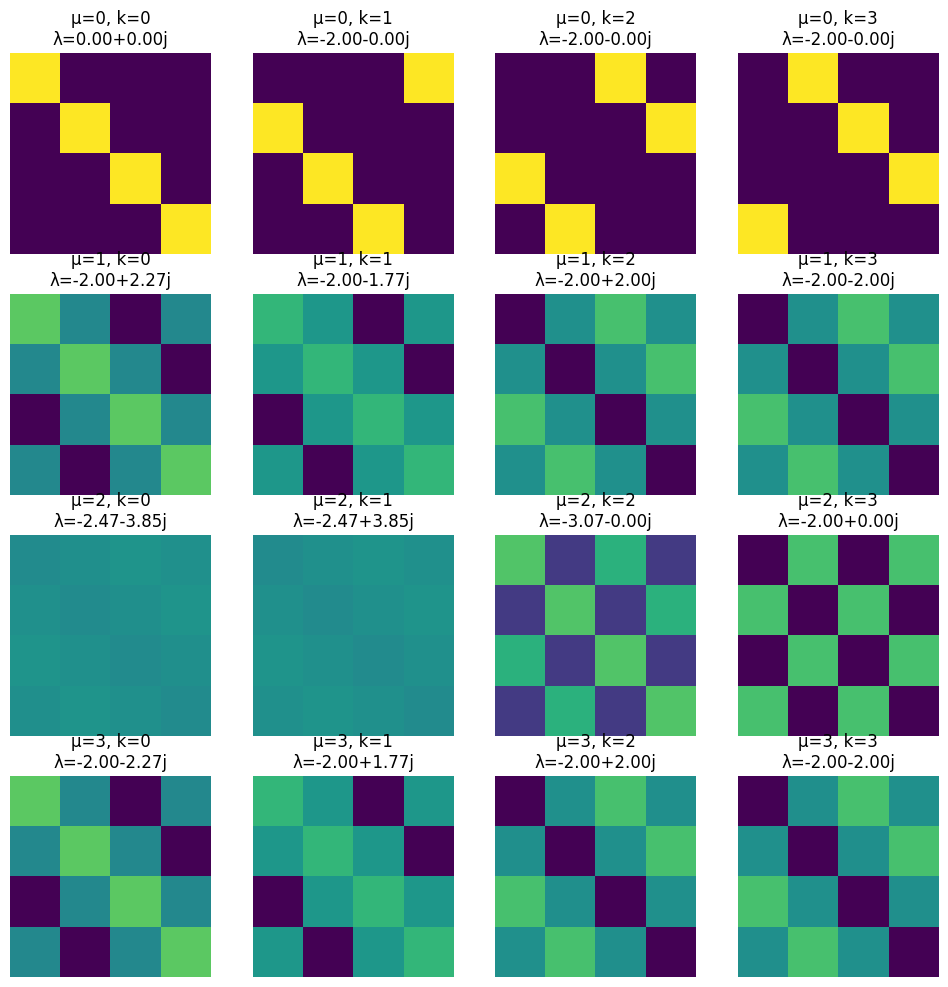

In [12]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
abs_max = np.max([abs(v) for v in evecs_dic.values()])
abs_min = np.min([abs(v) for v in evecs_dic.values()])

for mu in range(4):
    for k in range(4):
        idx = mu * 4 + k
        ψ = evecs_dic[(mu, k)]
        λ = evals_dic[(mu, k)]
        d1 = np.ma.masked_less(np.abs(ψ.reshape(4, 4, order='F')), 1e-12)
        ax = axs[mu, k]
        ax.imshow(np.abs(ψ.reshape(4, 4, order='F')), cmap='viridis', vmin=abs_min, vmax=abs_max)
        ax.set_title(f"μ={mu}, k={k}\nλ={λ:.2f}")
        ax.axis('off')

In [13]:
def twirl_Z4(rho: np.ndarray) -> np.ndarray:
    """
    Apply the Z4 twirl to density matrix rho.
    
    Parameters
    ----------
    rho : np.ndarray, shape (4, 4)
        Input density matrix.
    
    Returns
    -------
    G_rho : np.ndarray, shape (4, 4)
        Twirled density matrix invariant under Z4.
    """
    # Define the cyclic shift operator U
    dim = rho.shape[0]
    U = np.zeros((dim, dim), dtype=complex)
    for i in range(dim):
        U[i, (i + 1) % dim] = 1
    # Apply the twirl
    G_rho = sum(np.linalg.matrix_power(U.conj().T, k) @ rho @ np.linalg.matrix_power(U, k) for k in range(4)) / 4
    return G_rho

def asymmetry(rho: np.ndarray) -> float:
    """
    Compute the quantum relative entropy S(rho || G[rho]) using the Z4 twirl.
    
    S = Tr[rho (log rho - log G[rho])]
    
    Parameters
    ----------
    rho : np.ndarray, shape (4, 4)
        Input density matrix.
    
    Returns
    -------
    S : float
        Quantum relative entropy asymmetry measure.
    """
    # Ensure Hermitian and normalized
    assert np.allclose(rho, rho.conj().T), "Input must be Hermitian"
    assert np.isclose(np.trace(rho), 1), "Input must be a valid density matrix (trace = 1)"
    
    G_rho = twirl_Z4(rho)
    # Compute matrix logarithms
    log_rho = logm(rho)
    log_G_rho = logm(G_rho)
    # Quantum relative entropy
    S = np.real(np.trace(rho @ (log_rho - log_G_rho)))
    return S

def mode_trace_norms(rho):
    """
    Given a 4x4 density matrix rho, decompose it into its Z4 sectors (mu=0..3)
    and compute the trace norm (sum of singular values) of each sectoral component.
    """
    N = rho.shape[0]
    # build the single-site shift U
    U = np.zeros((N, N), complex)
    for i in range(N):
        U[i, (i+1) % N] = 1
    # superoperator projector: rho_mu = (1/4) sum_k e^{-2pi i k mu /4} U^k rho U^{-k}
    norms = []
    for mu in range(N):
        rho_mu = np.zeros_like(rho, complex)
        for k in range(N):
            phase = np.exp(-2j * np.pi * k * mu / N)
            rho_mu += phase * np.linalg.matrix_power(U, k) @ rho @ np.linalg.matrix_power(U, -k)
        rho_mu /= N
        # trace norm = sum singular values
        svals = np.linalg.svd(rho_mu, compute_uv=False)
        norms.append(np.sum(np.abs(svals)))
    return norms

In [23]:
# Create global ordering 0..15 by descending real part
all_items = list(evals_dic.items())  # [((mu,k), lambda), ...]
# Sort by real part descending
sorted_all = sorted(all_items, key=lambda x: x[1].real, reverse=True)
ordering_global = {item[0]: rank+1 for rank, item in enumerate(sorted_all)}

ordering_global

{(0, 0): 1,
 (1, 2): 2,
 (3, 1): 3,
 (3, 2): 4,
 (1, 3): 5,
 (2, 3): 6,
 (0, 1): 7,
 (0, 2): 8,
 (0, 3): 9,
 (1, 0): 10,
 (1, 1): 11,
 (3, 3): 12,
 (3, 0): 13,
 (2, 1): 14,
 (2, 0): 15,
 (2, 2): 16}

In [27]:
# Construct rho1, rho2
a, b = 0, 0
rho1 = evecs_dic[(0,0)] + (evecs_dic[(0,1)] + evecs_dic[(0,3)])/3 + evecs_dic[(2,2)]*(2/3)
rho2 = evecs_dic[(0,0)] + evecs_dic[(0,2)]/4 + (evecs_dic[(2,0)]+evecs_dic[(2,1)])*(1/4) + (evecs_dic[(1,0)]+evecs_dic[(3,0)])*(1/4)

rho1 = rho1.reshape(4, 4, order='F')
rho2 = rho2.reshape(4, 4, order='F')

fn.print_matrix(rho2)
# Hermitize and renormalize
assert np.allclose(rho1, rho1.conj().T), "rho1 must be Hermitian"
assert np.allclose(rho2, rho2.conj().T), "rho2 must be Hermitian"
assert np.isclose(np.trace(rho1), 1), "rho1 must be normalized (trace = 1), but trace = {}".format(np.trace(rho1))
assert np.isclose(np.trace(rho2), 1), "rho2 must be normalized (trace = 1), but trace = {}".format(np.trace(rho2))
assert np.all(np.linalg.eigvals(rho1) >= 0), "rho1 must be positive semidefinite, but eigenvalues are {}".format(np.linalg.eigvals(rho1))
assert np.all(np.linalg.eigvals(rho2) >= 0), "rho2 must be positive semidefinite, but eigenvalues are {}".format(np.linalg.eigvals(rho2))

print("\n\nAsymmetry S(rho1) =", asymmetry(rho1), "*"*90)
print("\nrho1 =")
fn.print_matrix(rho1)
print("\n\nAsymmetry S(rho2) =", asymmetry(rho2), "*"*90)
print("\nrho2 =")
fn.print_matrix(rho2)


(0.3967-0j) 	0.0489j     	(0.127+0j)  	-0.0338j   
-0.0489j    	(0.197+0j)  	-0.0489j    	(-0.002-0j)
(0.127+0j)  	(-0+0.0489j)	(0.2093-0j) 	-0.0338j   
(-0+0.0338j)	(-0.002-0j) 	(-0+0.0338j)	(0.197-0j) 


Asymmetry S(rho1) = 0.2740779427649419 ******************************************************************************************

rho1 =
(0.3717-0j)     	(0.0833-0.0284j)	(-0.1066-0j)    	(0.0833-0.0284j)
(0.0833+0.0284j)	(0.1283-0j)     	(0.0833+0.0284j)	(0.1066+0j)     
(-0.1066+0j)    	(0.0833-0.0284j)	(0.3717+0j)     	(0.0833-0.0284j)
(0.0833+0.0284j)	(0.1066-0j)     	(0.0833+0.0284j)	(0.1283-0j)     


Asymmetry S(rho2) = 0.10241131563919148 ******************************************************************************************

rho2 =
(0.3967-0j) 	0.0489j     	(0.127+0j)  	-0.0338j   
-0.0489j    	(0.197+0j)  	-0.0489j    	(-0.002-0j)
(0.127+0j)  	(-0+0.0489j)	(0.2093-0j) 	-0.0338j   
(-0+0.0338j)	(-0.002-0j) 	(-0+0.0338j)	(0.197-0j) 


In [ ]:
%matplotlib osx

# Time evolution
t = np.linspace(0, 10, 100)
S1, S2 = np.zeros(len(t)), np.zeros(len(t))
modes1, modes2 = np.zeros((len(t), 4)), np.zeros((len(t), 4))
for t_idx, ti in enumerate(t):
    evo = expm(L_q * ti)
    r1_t = evo.dot(rho1.flatten('F')).reshape(4,4,order='F')
    r2_t = evo.dot(rho2.flatten('F')).reshape(4,4,order='F')
    modes1_t = mode_trace_norms(r1_t)
    modes2_t = mode_trace_norms(r2_t)
    modes1[t_idx,:] = modes1_t
    modes2[t_idx,:] = modes2_t
    S1[t_idx] = asymmetry(r1_t)
    S2[t_idx] = asymmetry(r2_t)

# Plot
plt.figure(figsize=(6,4))
plt.plot(t, S1, label='Asymmetry of ρ₁(t)')
plt.plot(t, S2, label='Asymmetry of ρ₂(t)')
plt.xlabel('Time t')
plt.ylabel('Quantum Asymmetry S')
plt.legend()
plt.title('Symmetry‐Twirl Asymmetry vs Time')
plt.tight_layout()
plt.yscale('log')
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
for mu in range(1,4):
    if np.max(modes1[:, mu]) > 1e-12 :
        ax.plot(t, modes1[:, mu], label=f'Mode {mu} of ρ₁(t)', linestyle='--', alpha=0.7)
    if np.max(modes2[:, mu]) > 1e-12 :
        ax.plot(t, modes2[:, mu], label=f'Mode {mu} of ρ₂(t)', linestyle='-', alpha=0.7)
plt.xlabel('Time t')
plt.ylabel('trace norm of mode')
plt.legend()
plt.title('')
plt.tight_layout()
plt.yscale('log')
plt.show()

: 

In [ ]:
import numpy as np
from functools import reduce
import functions as fn
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
from matplotlib.text import Text
from circuit_obj import Circuit
from itertools import product

from matplotlib import cm
from matplotlib.colors import LogNorm

# from joblib import Parallel, delayed
colors = ["#394F87", "#A0B2E8", "#F0BCC1", "#7F0E0E"]
cmap1 = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
norm = plt.Normalize(vmin=0, vmax=np.pi)
smJ = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)

In [ ]:
N = 20

# Circuit parameters
T = 100
circuit_realizations = 2
symmetry = ['U1', 'SU2', 'Z2', 'ZK'][3]
geometry = ['random', 'brickwork'][1]
alphaT = 5 # Parameter to slice the circuit thinner

# State parameters
state_type = ['pure', 'mixed'][0]
if state_type == 'pure': 
    state_realizations = 1
    p = 1
else:
    state_realizations = 10
    p = .8
    if p == 1: state_type = 'pure'

# Mask parameters
sites_to_keep = range(N-8, N)
Ns = len(sites_to_keep)
if symmetry == 'ZK':
    K = 4
    masks_dict = fn.load_mask_memory(N, K)
else:
    masks_dict = fn.gen_Q(N, Ns)[0]

alphas = np.array([1]) # np.r_[np.linspace(0.1, 2, 10)]
sites_to_keep

In [ ]:
qthrow = np.arange(N)[np.isin(np.arange(N), sites_to_keep, invert=True)]
fn.sector_sizes(4, 4)

In [ ]:
def initial_state_ZK(theta, K):
    '''
    Create the 
    l state as (R_y(theta) |J_max>_Ns) tensor (|J_max>_Ne)
    '''
    qkeep = np.array(sites_to_keep)
    qthrow = np.arange(N)[np.isin(np.arange(N), qkeep, invert=True)]
    
    # system:
    state_s = np.zeros(2**(len(qkeep)), dtype=np.complex128)
    sizes = fn.sector_sizes(len(qkeep), K)
    
    com = 0
    for k, size in enumerate(sizes):
        old_com = com
        com += size
        # state_s[old_com] = np.cos(theta/2)**(k) * np.sin(theta/2)**(K-k)# * np.sqrt(size)
        state_s[old_com:com] = np.cos(theta/2)**(k) * np.sin(theta/2)**(K-k)# * np.sqrt(size)
        
    state_s /= np.linalg.norm(state_s)    
    state_s = fn.permute_ZK_state(state_s, K)
    
    #environment: |J=0>_Ne
    state_e = np.zeros(2**(len(qthrow)), dtype=np.complex128)
    sizes = fn.sector_sizes(len(qthrow), K)
    
    # state_e[:sizes[0]] = 1
    state_e[0] = 1
    state_e /= np.linalg.norm(state_e) 
    state_e = fn.permute_ZK_state(state_e, K)
    
    state_initial = np.kron(state_e, state_s)
    state_initial /= np.linalg.norm(state_initial)

    return state_initial


In [ ]:
%matplotlib inline

In [ ]:
J2_s = fn.build_J2(len(sites_to_keep))
Jz_s = fn.build_Jz(len(sites_to_keep))

thetas = np.linspace(0.3,.5, 2)*np.pi # np.array([.3,.35,.4,.45,.5])[::2]*np.pi/2

thetas = np.array(list(map(int, np.linspace(.1, .9, 3)*2**Ns)))
thetas = np.array([57+1, 150+2, 222])
thetas = np.array([25, 131, 141, 222, -5]) #number

thetas = np.linspace(.0, 1, 50)*np.pi
thetas = np.array([.1, .25, .35, .5])*np.pi

fig2, axs = plt.subplots(1, len(thetas), figsize=(16, 8))
fig3, ax1s = plt.subplots(1, len(thetas), figsize=(16, 8))

renyis = []
for idx, theta in enumerate(thetas):
    state = initial_state_ZK(theta, K) # initial_state_SU2(theta)
    rho_s = fn.ptrace(state, sites_to_keep)
    rho_s_tw = fn.manual_ZK_tw(rho_s, K)
    U_ZK = fn.U_ZK_gen(len(sites_to_keep), K)
    # print(theta, np.trace(rho_s @ Jz_tot))
    
    cmap = cm.plasma.copy()
    cmap.set_bad(color='white')  # or 'none' for full transparency
    
    d1 = np.ma.masked_less(np.abs(U_ZK.conj().T @ rho_s @ U_ZK), 1e-12)
    im = axs[idx].imshow(d1, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')    
    d2 = np.ma.masked_less(np.abs(U_ZK.conj().T @ rho_s_tw @ U_ZK), 1e-12)
    im = ax1s[idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
    
    # im = axs[idx].imshow(np.abs(rho_s), cmap=cm.plasma, norm=LogNorm(1e-12, 1e0))    
    # im = ax1s[idx].imshow(np.abs(rho_s_tw), cmap=cm.plasma, norm=LogNorm(1e-12, 1e0))
    
    renyis.append(fn.renyi_divergence(rho_s, rho_s_tw, 1).real)  
fig3.colorbar(im, ax=ax1s[-1])
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(thetas, renyis, 'o--', color='black', label=r'$R_1$')
[*zip(thetas, renyis)]


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib as mpl

def imshow_vector(data, ax=None, cmap=cm.plasma, norm=None, **kwargs):
    """
    Create an imshow-like plot that maintains vector properties when saved.
    
    Parameters:
    -----------
    data : 2D numpy array
        The data to display as an image
    ax : matplotlib axes, optional
        The axes to plot on. If None, a new figure is created.
    cmap : matplotlib colormap, optional
        Colormap to use
    norm : matplotlib norm, optional
        Normalization for the colormap
    **kwargs : dict
        Additional arguments passed to PatchCollection
        
    Returns:
    --------
    collection : PatchCollection
        The collection of rectangles
    """
    # Create axes if not provided
    if ax is None:
        fig, ax = plt.subplots()
    
    # Get data dimensions
    ny, nx = data.shape
    
    # Create rectangles for each data point
    patches = []
    for y in range(ny):
        for x in range(nx):
            rect = Rectangle((x, ny-1-y), 1, 1)  # (x, y, width, height)
            patches.append(rect)
    
    # Create a PatchCollection with the rectangles
    collection = PatchCollection(patches, **kwargs)
    
    # Flatten data for mapping to colors
    if norm is None:
        norm = mpl.colors.Normalize(vmin=data.min(), vmax=data.max())
        
    # Map data to colors
    colors = cmap(norm(data.flatten()))
    collection.set_facecolor(colors)
    
    # Add collection to the axes
    ax.add_collection(collection)
    
    # Set axes limits
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    
    # Create a ScalarMappable for the colorbar
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])  # Empty array needed for older matplotlib versions
    
    return collection, sm


state = initial_state_ZK(theta, K) # initial_state_SU2(theta)
rho_s = fn.ptrace(state, sites_to_keep)
rho_s_tw = fn.manual_ZK_tw(rho_s, K)
rho_s_tw_in_ZK = U_ZK @ rho_s_tw @ U_ZK.conj().T

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Use the vector imshow function with LogNorm
norm = LogNorm(1e-8, 1e0)

cmap = cm.plasma.copy()
cmap.set_bad(color='white')  # or 'none' for full transparency

d1 = np.ma.masked_less(np.abs(rho_s_tw_in_ZK), 1e-12)
collection, sm = imshow_vector(d1, ax=ax, cmap=cm.plasma, norm=norm, edgecolor='none')    

# Add colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Value')

# Set title and labels
ax.set_title('Vector-based Visualization of sigma_tw_ZK (LogNorm scale)')
ax.set_xlabel('Column Index')
ax.set_ylabel('Row Index')

# Save the plot in vector format
plt.savefig('sigma_tw_ZK_vector.pdf')
# plt.savefig('sigma_tw_CG_vector.svg')

print("Plot saved in vector formats: sigma_tw_ZK__vector.pdf and sigma_tw_ZK__vector.svg")
plt.show()

# For comparison, create a standard imshow plot (which will be rasterized)
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
im = ax2.imshow(np.abs(d1), cmap=cm.plasma, norm=LogNorm(1e-8, 1e0))
fig2.colorbar(im, ax=ax2)
ax2.set_title('Standard imshow of sigma_tw_ZK_ (will be rasterized)')
ax2.set_xlabel('Column Index')
ax2.set_ylabel('Row Index')

plt.savefig('sigma_tw_ZK_raster.pdf')
print("Rasterized version saved as: sigma_tw_ZK__raster.pdf")
plt.show()

In [ ]:
# given an initial state see how the modes are already populated 
U_ZK_s = fn.U_ZK_gen(len(sites_to_keep), K)
sectors_s = fn.sector_sizes(Ns, K)
fig, axs = plt.subplots(len(thetas), K, figsize=(16, 16))
renyis = []
for theta_idx, theta in enumerate(thetas):
    state = initial_state_ZK(theta, K) # initial_state_SU2(theta)
    
    rho_s = fn.ptrace(state, sites_to_keep)
    rho_s = U_ZK_s.conj().T @ rho_s @ U_ZK_s
    rho_s_traces = fn.asymmetry_modes(rho_s, sectors_s)
    
    for omega_idx, rho_omega in enumerate(rho_s_traces):
        d2 = np.ma.masked_less(np.abs(rho_omega), 1e-12)
        im = axs[theta_idx, omega_idx].imshow(d2, cmap=cmap, norm=LogNorm(1e-12, 1e0), interpolation='none')
    

In [ ]:
gates = [fn.generate_Zk_gate(K, alphaT) for _ in range(N//2)]
order = np.append(np.arange(0, N, 4), np.arange(2, N, 4))
order

In [ ]:
Q_op = np.diag([np.exp(2j * np.pi * (bin(i).count('1') % K) / K) for i in range(2**K)])

norms_s = np.zeros((len(thetas), 10, K))
U_ZK_s = fn.U_ZK_gen(len(sites_to_keep), K)
sectors_s = fn.sector_sizes(Ns, K)
norms_e = np.zeros((len(thetas), 10, K))
U_ZK_e = fn.U_ZK_gen(len(qthrow), K)
sectors_e = fn.sector_sizes(N-Ns, K)
norms_se = np.zeros((len(thetas), 10, K))
U_ZK_se = fn.U_ZK_gen(N, K)
sectors_se = fn.sector_sizes(Ns, K)

def compute_norm(op):
    """
    Compute the trace‐norm (sum of singular values) of a matrix/operator safely.

    Parameters
    ----------
    op : array‐like, shape (m, n)
        The input operator.

    Returns
    -------
    float
        The nuclear norm of `op`.
    """
    # 1) Coerce to a 2D ndarray
    A = np.asarray(op, dtype=np.complex128)
    if A.ndim != 2:
        raise ValueError(f"Expected a 2D array, got shape {A.shape}")

    # 2) Compute singular values via SVD (more stable than sqrtm of A A^*)
    #    Only singular values are needed, so compute_uv=False
    s = np.linalg.svd(A, compute_uv=False)

    # 3) Sum singular values (trace‐norm) and return as a real float
    return float(np.sum(s))

for theta_idx, theta in enumerate(thetas):

    print(theta_idx, theta)
    state = initial_state_ZK(theta, K) #initial_state_SU2(theta)
    state /= np.linalg.norm(state)
    
    rho_s = fn.ptrace(state, sites_to_keep)
    rho_s = U_ZK_s.conj().T @ rho_s @ U_ZK_s
    rho_s_traces = fn.asymmetry_modes(rho_s, sectors_s)
    norms_s[theta_idx, 0, :] = [compute_norm(rho_omega).real for rho_omega in rho_s_traces]
    
    rho_e = fn.ptrace(state, qthrow)
    rho_e = U_ZK_e.conj().T @ rho_e @ U_ZK_e
    rho_e_traces = fn.asymmetry_modes(rho_e, sectors_e)
    norms_e[theta_idx, 0, :] = [compute_norm(rho_omega).real for rho_omega in rho_e_traces]
    
    rho_se = U_ZK_se.conj().T @ state
    rho_se = np.outer(rho_se, rho_se.conj())
    rho_se_traces = fn.asymmetry_modes(rho_se, sectors_se)
    norms_se[theta_idx, 0, :] = [compute_norm(rho_omega).real for rho_omega in rho_se_traces]
    
    for t in tqdm(range(1, 10)):    
        state = fn.apply_U(state, gates, order, masks_dict, K)

        rho_s = fn.ptrace(state, sites_to_keep)
        rho_s = U_ZK_s.conj().T @ rho_s @ U_ZK_s
        rho_s_traces = fn.asymmetry_modes(rho_s, sectors_s)
        norms_s[theta_idx, t, :] = [compute_norm(rho_omega).real for rho_omega in rho_s_traces]
        
        rho_e = fn.ptrace(state, qthrow)
        rho_e = U_ZK_e.conj().T @ rho_e @ U_ZK_e
        rho_e_traces = fn.asymmetry_modes(rho_e, sectors_e)
        norms_e[theta_idx, t, :] = [compute_norm(rho_omega).real for rho_omega in rho_e_traces]
    
        rho_se = U_ZK_se.conj().T @ state
        rho_se = np.outer(rho_se, rho_se.conj())
        rho_se_traces = fn.asymmetry_modes(rho_se, sectors_se)
        norms_se[theta_idx, 0, :] = [compute_norm(rho_omega).real for rho_omega in rho_se_traces]


In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# axs = axs.flatten()

for theta_idx, theta in enumerate(thetas):
    colors = ['#394F87', '#A0B2E8', '#F0BCC1', '#7F0E0E'][theta_idx]
    for omega in range(K):
        norm_K_s = norms_s[theta_idx, :, omega]
        norm_K_e = norms_e[theta_idx, :, omega]
        norm_K_se = norms_se[theta_idx, :, omega]
        ls = ['-', '--', '-.', ':'][omega]
        axs[0].plot(range(10), norm_K_s, ls=ls, label=r'$\omega={\pm %d}$' % omega + r'; $\theta={%.2f}\pi$' % (theta/np.pi), marker='o', color=colors)
        axs[1].plot(range(10), norm_K_e, ls=ls, label=r'$\omega={\pm %d}$' % omega + r'; $\theta={%.2f}\pi$' % (theta/np.pi), marker='o', color=colors)
        axs[2].plot(range(10), norm_K_se, ls=ls, label=r'$\omega={\pm %d}$' % omega + r'; $\theta={%.2f}\pi$' % (theta/np.pi), marker='o', color=colors)
        # axs[2].plot(range(10), norm_K_s+norm_K_e, ls=ls, label=r'$\omega={\pm %d}$' % omega + r'; $\theta={%.2f}\pi$' % (theta/np.pi), marker='o', color=colors, alpha=1)
axs[0].set_title('System')
axs[1].set_title('Environment')
axs[2].set_title('System+Environment')
axs[0].set_xlabel('Time')
axs[1].set_xlabel('Time')
axs[2].set_xlabel('Time')
# axs[2].set_yscale('symlog')
axs[0].legend()

In [ ]:
from scipy.linalg import expm

ones = reduce(np.kron, [fn.gate_Z2() for i in range(Ns//2)]) # np.ones((2**Ns, 2**Ns))
ones_tw = fn.manual_ZK_tw(ones, K)
U_ZK = fn.U_ZK_gen(Ns, K)
ones_tw_ZK = (U_ZK.conj().T @ (ones_tw) @ U_ZK)

s_ZK = reduce(np.kron, [expm(1j * np.pi/K * fn.Z)] * Ns)
# fn.print_matrix(ones_tw_ZK.real)
# fn.print_matrix((U_ZK.conj().T @ s_ZK.conj().T @ ones_tw @ s_ZK @ U_ZK   - ones_tw_ZK).real)
print(np.allclose(s_ZK.conj().T @ ones_tw @ s_ZK, ones_tw))
fn.print_matrix((s_ZK.conj().T @ ones_tw @ s_ZK  - ones_tw).real)

In [ ]:
data = np.load(f"data/{symmetry}_{geometry}_N{N}_N_A{Ns}_T{T}_alphaT{alphaT}_state{state_type}_p{p}_theta{thetas[0]}_{thetas[-1]}_circuit{circuit_realizations}_{alphas}.npz")
res = data['res']

# res = res[:,:,:,10:13,:]
# alphas = alphas[10:13]

# Check subsectors of initial states:

In [ ]:
from quspin.basis import spin_basis_1d
# Create a dictionary to hold projectors for each magnetization subsector.
# Here we assume the magnetization m runs from -NA/2 to NA/2 in steps of 1.
projectors = {}
U_U1_8 = np.zeros((2**Ns, 2**Ns), dtype=np.complex128)
row_index = 0
old_basis = None
for m in np.linspace(-.5, .5, Ns+1):
    # Retrieve the list of computational basis states for this magnetization sector.
    # (Assuming spin_basis_1d(NA, m=m) returns an object with a member .states.)
    if old_basis is not None:
        it = 0
        while old_basis.Ns == spin_basis_1d(Ns, m=m).Ns:
            m += 1e-7
            it += 1
            if it > 1000:
                print("Warning: too many iterations")
                break
    
    basis_obj = spin_basis_1d(Ns, m=m)
    old_basis = basis_obj
            
    states_m = basis_obj.states
    print(f"Magnetization m {m:.2f} has", len(states_m), "states: states_m =", states_m)
    for state in states_m[::-1]:
        U_U1_8[state, row_index] = 1
        row_index += 1
    # Compute the projector onto the subspace spanned by these states.
    projectors[m] = fn.compute_projector(Ns, states_m)

# reordered projectors:
reordered_projectors = {}
for m in projectors.keys():
    reordered_projectors[m] = U_U1_8.T @ projectors[m] @ U_U1_8

In [ ]:
states = []
sss = []
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax,ax1 = axs
for theta in thetas:
    state = initial_state_SU2(state_s, state_e, theta) #fn.initial_state(N, sites_to_keep, theta, state_phases)
    state /= np.linalg.norm(state)

    magns = []
    size_space = []
    old_basis = None
    # compute magnetization of pure state
    for m in np.linspace(-.5, .5, N+1):
        # Retrieve the list of computational basis states for this magnetization sector.
        # (Assuming spin_basis_1d(NA, m=m) returns an object with a member .states.)
        if old_basis is not None:
            it = 0
            while old_basis.Ns == spin_basis_1d(N, m=m).Ns:
                m += 1e-7
                it += 1
                if it > 1000:
                    print("Warning: too many iterations")
                    break

        basis_obj = spin_basis_1d(N, m=m)
                
        states_m = basis_obj.states
        magn =  np.sum(np.abs(state[states_m])**2)
        magns.append(magn)
        size_space.append(basis_obj.Ns)
        
        old_basis = basis_obj
        
    assert np.sum(size_space) == 2**N
    
    ax.plot(np.linspace(-.5, .5, N+1), magns, label=f"$\\theta = {theta/np.pi:.2f} \pi$", marker='.')
    
    sss.append(fn.ptrace(state, sites_to_keep))
    states.append(state)
    
    print('theta', theta, 'magnetization', np.sum(magns * np.linspace(-.5, .5, N+1)))
ax1.plot(np.linspace(-.5, .5, N+1), size_space, label='size space', marker='.')
ax.set_xticks(np.linspace(-.5, .5, N+1))
ax.set_xlabel("Magnetization")
ax.set_ylabel("Probability")
ax.legend()
plt.savefig(f"plots/magnetization_{N}_{Ns}.pdf")

In [ ]:
overlaps = []
for state in sss:
    overlap = {}
    for m in projectors.keys():
        overlap[m] =  np.trace(projectors[m] @ state @ projectors[m])
        print(m, overlap[m], end=' ')
    # sort the overlap dictionary by the keys
    overlap = dict(sorted(overlap.items()))
    # convert the overlap dictionary to an array
    overlap = np.array(list(overlap.values()))
    overlaps.append(overlap)
    print()


fig, axs = plt.subplots(ncols=2, figsize=(12, 6))  # Adjust figsize as needed
for i, overlap in enumerate(overlaps):
    theta_label = thetas[i] / np.pi
    axs[0].plot(overlap, label=fr"$\theta = {theta_label}\ \pi$", marker='o')
    summed_overlap = overlap[:len(overlap)//2] + overlap[len(overlap)//2+1:][::-1]
    # If the length is odd, include the middle element
    if len(overlap) % 2 != 0:
        middle_element = overlap[len(overlap)//2]
        summed_overlap = np.append(summed_overlap, middle_element)
    axs[1].plot(summed_overlap, label=fr"$\theta = {theta_label}\ \pi$", marker='o')
axs[0].legend()
plt.show()

In [ ]:
import numpy as np
import functions as fn



In [ ]:
Na, Ka = 10, 4
first = 3 # 3, 4, 5, 6

# random state + gate
state = np.random.randn(2**Na) + 1j*np.random.randn(2**Na)
state /= np.linalg.norm(state)
# random unitary
gate = fn.generate_Zk_gate(Ka, alphaT)

# Generate masks and apply functions
masks = fn.get_masks_typed(Na, first, Ka)


out_numba = fn.apply_gate_k(state, gate, masks)

# brute-force via kron
I_lo = np.eye(2**first)
I_hi = np.eye(2**(Na-first-Ka))
full = np.kron(I_hi, np.kron(gate, I_lo))
out_bruteforce = full.dot(state)

print("|| out_numba – out_bf || =", np.linalg.norm(out_numba - out_bruteforce))

In [ ]:


# Example usage:
K = 4
U = fn.generate_Zk_gate(K, alphaT)
# Verify unitarity and symmetry
print("||U†U - I|| =", np.linalg.norm(U.conj().T @ U - np.eye(2**K)))
fn.print_matrix(U)
# Build Q operator and check commutation
Q_op = np.diag([np.exp(2j * np.pi * (bin(i).count('1') % K) / K) for i in range(2**K)])
print("||[U, Q]|| =", np.linalg.norm(U @ Q_op - Q_op @ U))

fn.print_matrix(Q_op)

In [ ]:
import importlib
import circuit_obj, functions
importlib.reload(circuit_obj)
importlib.reload(functions)
Circuit = circuit_obj.Circuit
fn = functions

In [ ]:
T = 20
circuit_realizations = 10

In [ ]:
circuits = []

U_ZK_s = fn.U_ZK_gen(len(sites_to_keep), K)
sectors_s = fn.sector_sizes(Ns, K)

for circuit_realization in range(circuit_realizations):
    if symmetry == 'U1':
        h_list = np.random.uniform(-np.pi, np.pi, 5*N).reshape(N, 5) /alphaT
        gates = [fn.gen_u1(h) for h in h_list]
    elif symmetry == 'SU2' or symmetry == 'z2':
        h_list = np.random.uniform(-np.pi, np.pi, 1*N).reshape(N, 1) /alphaT
        gates = [fn.gen_su2(*h) for h in h_list]
    elif symmetry in ['Z2']: # not the most generic
        h_list = np.random.uniform(-np.pi, np.pi, 5*N).reshape(N, 5) /alphaT
        gates = [fn.gen_z2(h) for h in h_list]
    elif symmetry == 'ZK':
        if N!=20 and K!=4:
            raise ValueError("Only N=20 and K=4 are supported for ZK symmetry")
        gates = [fn.generate_Zk_gate(K, alphaT) for _ in range(N//2)]

    if symmetry == 'ZK':
        if N!=20 and K!=4:
            raise ValueError("Only N=20 and K=4 are supported for ZK symmetry")
        order = np.append(np.arange(0, N, 4), np.arange(2, N, 4))
    else:
        order = fn.gen_gates_order(N, geometry=geometry)

    circuit = Circuit(N=N, T=T, gates=gates, order=order, symmetry=symmetry, K=(None if symmetry!='ZK' else K))
    circuit.projectors = None
    circuit.U_U1_s = U_ZK_s.conj().T
    circuit.sectors_s = sectors_s
    circuit.Ns = Ns
    circuit.snapshots_t = np.arange(T+1)
    circuits.append(circuit)

def compute_circuit(theta, circuit_real):
    circuit = circuits[circuit_real]
    if state_type == 'pure':
        state = initial_state_ZK(theta, K) #initial_state_SU2(theta) #fn.initial_state(N, sites_to_keep, theta, state_phases)
        state /= np.linalg.norm(state)
    else:
        raise ValueError("State type not supported")
    return circuit.run(masks_dict, sites_to_keep, alphas, state)

if globals().get('res') is None or globals(
    ).get('res').shape != (circuit_realizations, len(thetas), state_realizations, len(alphas), T+1):
    res = np.zeros((circuit_realizations, len(thetas), state_realizations, len(alphas), T+1))
    if symmetry == 'Z2':
        res1 = np.zeros((circuit_realizations, len(thetas), state_realizations, 2, T+1))
    
if globals().get('norms_s') is None or globals(
    ).get('norms_s').shape != (circuit_realizations, len(thetas), T + 1, K):
    norms_s = np.zeros((circuit_realizations, len(thetas), T + 1, K), dtype=float)
    
if globals().get('evo') is None or globals(
    ).get('evo').shape != (circuit_realizations, len(thetas), T + 1, 2**N):
    evo = np.zeros((circuit_realizations, len(thetas), T + 1, 2**N), dtype=float)
    
import warnings
warnings.simplefilter("ignore", category=UserWarning)

print("Computing circuits for thetas:", thetas)
for theta_i, circuit_real, state_real in tqdm(product(
        range(len(thetas)),
        range(circuit_realizations), 
        range(state_realizations)
    ), total=len(thetas)*circuit_realizations*state_realizations):
        theta = thetas[theta_i]
        res[circuit_real, theta_i, state_real, :, :], norms_s[circuit_real, theta_i],     \
            evo[circuit_real, theta_i] = compute_circuit(theta, circuit_real)

In [ ]:
import os
# MUST do this before importing numpy/numba or any parallel code
os.environ['OMP_MAX_ACTIVE_LEVELS'] = '3'
os.environ['NUMBA_THREADING_LAYER'] = 'omp'

In [ ]:
GATE1 = fn.gate_Z2(np.random.uniform(-np.pi, np.pi, 6))
GATE2 = fn.gate_Z2(np.random.uniform(-np.pi, np.pi, 6))
GATE3 = fn.gate_Z2(np.random.uniform(-np.pi, np.pi, 6))
GATES = np.kron(GATE1, GATE2) @ np.kron(np.eye(2), np.kron(GATE3, np.eye(2)))

Z2 = reduce(np.kron, [fn.sz] * 4)

fn.print_matrix(Z2 @ GATES - GATES @ Z2)

In [ ]:
np.save(f'data/{symmetry}_{N}_{T}_{1}_{state_type}_{circuit_realizations}_{state_realizations}_{len(thetas)}', res)
# res = np.load(f'data/{symmetry}_{N}_{T}_{alpha}_{state_type}_{state_phases}_{circuit_realizations}_{state_realizations}_{len(thetas)}.npy')

#  End of part that we need to run on Kesha 

In [ ]:
steps = range(T+1)
# steps = []
# for t in range(T+1):
#     if t <= 33 or (t <= 100 and t  %   2 == 0) or \
#         (t <= 330 and t  %   5 == 0) or \
#         (t <= 1000 and t %  10 == 0) or \
#         (t <= 3300 and t %  50 == 0) or \
#         (t  > 3300 and t % 100 == 0):
#         steps.append(t)
    
    
len(steps)


In [ ]:
%matplotlib osx

In [ ]:
from matplotlib.ticker import ScalarFormatter
from scipy.ndimage import gaussian_filter
alphas = alphas[(.7 < alphas) & (alphas < 1.5)]
if len(alphas) == 1:
    fig, axs = plt.subplots(1, 1, figsize=(8, 5))
else:
    fig, axs = plt.subplots(2, len(alphas)//2, figsize=(15, 8))
    axs = axs.flatten()
# fig, axs2 = plt.subplots(1, len(functions), figsize=(15, 6))

plt.suptitle(rf"State: {state_type}, $N$ = {N}, $N_A$ = {Ns}, pure, zero on Env, #circuits = {circuit_realizations}, $Z${K} symmetry")

crossings = np.zeros((len(alphas), len(thetas)-1))
for theta_idx, theta in enumerate(thetas[::]):

    label_theta = f"0.{int(np.round(100*theta/np.pi))} " + r'$\pi$'
    color_theta = cmap1(theta/max(thetas))

    for alpha_idx, alpha in enumerate(alphas):
        if len(alphas) == 1:
            ax_i = axs
        else: 
            ax_i = axs[alpha_idx]
            # ax_j = axs2[fidx]
        y_vals = np.nanmean(res[:, theta_idx, :, alpha_idx, :], axis=(0,1))[steps]
        # y_vals_old = np.nanmean(res_old[:, theta_idx, :, alpha_idx, :], axis=(0,1))[steps]
        
        y_std = np.std(res[:, theta_idx, :, alpha_idx, :], axis=(0,1))
        
        # replace nan with 1
        y_vals[np.isnan(y_vals)] = 1e-20
        
        # fetch time steps as values of y_vals != 0
        time_steps = np.where(y_vals > 1e-20)[0]
        
        # y_vals = gaussian_filter(y_vals, sigma=.002)
        ax_i.plot(np.arange(1, T+2)[steps], y_vals, label=label_theta, marker=',')
        # ax_i.plot(np.arange(1, T+2)[steps], y_vals_old, label=label_theta, 
        #           marker=',', color=ax_i.lines[-1].get_color(), ls='--')
        # ax_i.fill_between(range(T+1), y_vals-y_std, y_vals+y_std, color=color_theta, alpha=.1, lw=0)

        if alpha_idx == 0: ax_i.legend()
        ax_i.set_title(f"{alpha}")
        if theta_idx != 0:
            cross = np.where(np.diff(np.sign(y_vals_old - y_vals)))[0]
            if len(cross) > 0:
                crossings[alpha_idx][theta_idx-1] = cross[0]
        y_vals_old = y_vals
        # gaussian filter on y_vals
        
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((-3, 3))
        formatter.set_scientific(True)
        formatter.set_useOffset(False)
        ax_i.yaxis.set_major_formatter(formatter) 
        ax_i.set_xscale('log'); ax_i.set_xlabel(r"$t$")
        ax_i.set_yscale('log'); ax_i.set_ylabel(rf"$S_{alpha} (\hat \rho_S || G (\hat \rho_S))$")
        ax_i.set_xlim(1*.9, T*1.1)
plt.tight_layout()
plt.savefig(f"plots/{N}_{Ns}_{state_type}_{p}_{circuit_realizations}_{state_realizations}.pdf")
plt.show()


In [ ]:
from matplotlib.ticker import ScalarFormatter
from scipy.ndimage import gaussian_filter
alphas = alphas[(.7 < alphas) & (alphas < 1.5)]
if len(alphas) == 1:
    fig, axs = plt.subplots(1, 1, figsize=(8, 5))
else:
    fig, axs = plt.subplots(2, len(alphas)//2, figsize=(15, 8))
    axs = axs.flatten()
# fig, axs2 = plt.subplots(1, len(functions), figsize=(15, 6))

plt.suptitle(rf"State: {state_type}, $N$ = {N}, $N_A$ = {Ns}, pure, zero on Env, #circuits = {circuit_realizations}, $SU(2)$")

crossings = np.zeros((len(alphas), len(thetas)-1))
for theta_idx, theta in enumerate(thetas[:-1]):
    print(theta_idx, theta)

    label_theta = f"0.{int(np.round(100*theta/np.pi))} " + r'$\pi$'
    color_theta = cmap1(theta/max(thetas))

    ax_i = axs
    y_vals0 = np.nanmean(res1[:, theta_idx, :, 0, :], axis=(0,1))[steps]
    y_vals1 = np.nanmean(res1[:, theta_idx, :, 1, :], axis=(0,1))[steps]
    
    if theta_idx == 1:
        ax_i.plot(np.arange(1, T+2)[steps], y_vals0-.25, label=label_theta, marker=',')
    else:
        ax_i.plot(np.arange(1, T+2)[steps], y_vals0, label=label_theta, marker=',')
    ax_i.plot(np.arange(1, T+2)[steps], y_vals1, label=label_theta, marker=',', ls='--')

    if alpha_idx == 0: ax_i.legend()
    ax_i.set_title(f"{alpha}")
    if theta_idx != 0:
        cross = np.where(np.diff(np.sign(y_vals_old - y_vals)))[0]
        if len(cross) > 0:
            crossings[alpha_idx][theta_idx-1] = cross[0]
    y_vals_old = y_vals
    # gaussian filter on y_vals
    
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 3))
    formatter.set_scientific(True)
    formatter.set_useOffset(False)
    ax_i.yaxis.set_major_formatter(formatter) 
    ax_i.set_xscale('log'); ax_i.set_xlabel(r"$t$")
    ax_i.set_yscale('log'); #ax_i.set_ylabel(rf"$S_{alpha} (\hat \rho_S || G (\hat \rho_S))$")
    ax_i.set_xlim(1*.9, 100*1.1)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the following variables are defined:
# alphas: iterable of alpha values (e.g., [0.5, 1.5, ...])
# thetas: iterable of theta values
# res: a NumPy array with dimensions (circuit_realizations, len(thetas), ?, len(alphas), ?)
# steps: indices to select a subset of time steps
# T: the maximum time step value (used for plotting axes)

num_alphas = len(alphas)
num_thetas = len(thetas)

# Initialize a 3D array to store the crossing index for each alpha and for each theta pair (i, j) with i > j.
# We'll set missing values (including the upper triangle and diagonal) as NaN.
crossing_data = np.full((num_alphas, num_thetas, num_thetas), np.nan)

tol = 1e-20  # Tolerance for near-zero differences

x_vals = np.arange(1, T+2)[steps]

for alpha_idx, alpha in enumerate(alphas):
    for i in range(num_thetas):
        y_vals_i = np.nanmean(res[:, i, :, alpha_idx, :], axis=(0, 1))[steps]
        for j in range(i):
            y_vals_j = np.nanmean(res[:, j, :, alpha_idx, :], axis=(0, 1))[steps]
            diff = y_vals_i - y_vals_j
            # diff[np.abs(diff) < tol] = 0
            cross = np.where(np.diff(np.sign(diff)))[0]
            if len(cross) > 0:
                line_int = fn.line_intersection(x_vals, y_vals_i, y_vals_j, cross[0])
                crossing_data[alpha_idx, i, j] = line_int[1] 

if num_alphas == 1:
    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    ax = [axs]
else:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))


for i, theta_i in enumerate(thetas):
    label_theta_i = f"0.{int(np.round(100*theta_i/np.pi))} " + r'$\pi$'
    for j, theta_j in enumerate(thetas):
        if i <= j:
            continue
        label_theta_j = f"0.{int(np.round(100*theta_j/np.pi))} " + r'$\pi$'
        ax.plot(alphas, crossing_data[:, i, j], label=f"Crossing {label_theta_i} vs {label_theta_j}", marker='o')
        print(crossing_data[:, i, j])

plt.legend()
ax.set_xscale('log')
plt.tight_layout()
plt.savefig(f"plots/crossing_{N}_{Ns}_{state_type}_{p}_{circuit_realizations}_{state_realizations}_{state_phases}.pdf")
plt.show()


In [ ]:
def line_intersection(x_vals, y_vals_i, y_vals_j, cross):
    """
    Computes the intersection of two lines defined by points a, b and c, d.
    
    Parameters:
      a, b: Tuples (x, y) defining the first line.
      c, d: Tuples (x, y) defining the second line.
      
    Returns:
      A tuple (x, y) representing the intersection point.
      
    Raises:
      ValueError: If the lines are parallel (i.e., no unique intersection).
    """
    t1, t2 = x_vals[cross], x_vals[cross + 1]
    a, b = y_vals_i[cross], y_vals_i[cross + 1]
    c, d = y_vals_j[cross], y_vals_j[cross + 1]
    # Define points for the two lines
    x_a = x_c = t1
    x_b = x_d = t2
    y_a = a
    y_b = b
    y_c = c
    y_d = d

    # Calculate slopes (handle vertical lines)
    if x_b != x_a:
        m_ab = (y_b - y_a) / (x_b - x_a)
    else:
        m_ab = None  # vertical line

    if x_d != x_c:
        m_cd = (y_d - y_c) / (x_d - x_c)
    else:
        m_cd = None  # vertical line

    # Check for parallel lines or identical slopes
    if m_ab == m_cd:
        plt.loglog(x_vals[cross-10:cross+10], y_vals_i[cross-10:cross+10], label='Line 1', color='blue')
        plt.loglog(x_vals[cross-10:cross+10], y_vals_j[cross-10:cross+10], label='Line 2', color='red')
        plt.loglog([x_a, x_b], [y_a, y_b], color='blue', linestyle='--')
        plt.loglog([x_c, x_d], [y_c, y_d], color='red', linestyle='--')
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Lines are parallel or coincident')
        plt.grid()
        plt.show()
        raise ValueError("The lines are parallel or coincident; no unique intersection exists.", 
                         (x_a, y_a), (x_b, y_b), (x_c, y_c), (x_d, y_d))
    
    # If one of the lines is vertical, handle separately
    if m_ab is None:
        # Line ab is vertical, so x is constant = x_a
        x_int = x_a
        # Use line cd to find y
        y_int = y_c + m_cd * (x_int - x_c)
    elif m_cd is None:
        # Line cd is vertical, so x is constant = x_c
        x_int = x_c
        # Use line ab to find y
        y_int = y_a + m_ab * (x_int - x_a)
    else:
        # Both lines are non-vertical: solve for x from the equality:
        # y_a + m_ab*(x - x_a) = y_c + m_cd*(x - x_c)
        # => (m_ab - m_cd)*x = m_ab*x_a - y_a - m_cd*x_c + y_c
        x_int = (m_ab*x_a - y_a - m_cd*x_c + y_c) / (m_ab - m_cd)
        y_int = y_a + m_ab * (x_int - x_a)
    
    return (x_int, y_int)

fn.line_intersection = line_intersection

In [ ]:
y_vals

# Test optimal number of threads

In [ ]:
Ns = np.array(      [ 4,  6,  8,    10,   12,  14,16, 18, 20, 22,  24,   26,    28, 30])
Ts_numba = np.array([1.1, 1.7, 2.3, 2.9, 3.5, 4.5, 7, 14, 47, 520, 2120, 9e3, 40400])/1000
# 4->2 threads, 8->8, 18->40(?), 22->85(?)


Ts = np.array(      [.0213, .0363, .06, .117, .376, 5.3, 27, 89, 346, 1450, 6710])/1000

# ON MY COMPUTER!!
Ts_u1 = np.array([.15, .26, .5, .4, .5, .67, .936, 2, 12, 50, 380, 1570])/1000
Ts_u1_nonumba = np.array([.06, .09, .15, .22, .46, 1.89, 11.6, 28.9, 219, 975, 4770, 20500])/1000

# ON Kesha
Ts_u1_kesha = np.array([.71, 1.05, 1.40, 1.78, 2.1, 2.87, 3.62, 5, 10, 25, 71, 419, 5890, 25200])/1000
Ts_u1_kesha_nonumba = np.array([.03, .09, .07, .10, .23, .68, 3.4, 17.1, 84, 434, 4770, 18500, 78100])/1000

plt.semilogy(Ns[:-3], Ts, marker='o', label='simple code')
plt.semilogy(Ns[:-1], Ts_numba, marker='x', label='new code')
plt.semilogy(Ns, Ts_u1_kesha, marker='.', label='U(1) new code, kesha', c='r')
plt.semilogy(Ns[:-1], Ts_u1_kesha_nonumba, marker='^', label='U(1) old code, kesha', c='b')
plt.semilogy(Ns[:-2], Ts_u1, marker='.', label='U(1) new code', c='k', ls='--')
plt.semilogy(Ns[:-2], Ts_u1_nonumba, marker='^', label='U(1) old code', c='k', ls='--')
plt.axhline(60, color='r', linestyle='--')

# Get current y-ticks
yticks = plt.gca().get_yticks(); yticks = np.append(yticks, 60); plt.gca().set_yticks(yticks)
ylabels = plt.gca().get_yticklabels(); ylabels[-1] = Text(0, 0, '1min'); plt.gca().set_yticklabels(ylabels)

plt.ylabel('Time taken to apply U (seconds)')
plt.xlabel('System Size (N)')
plt.xticks(Ns)
plt.legend()
Ts_numba[:-2]/Ts

In [ ]:
import numba
import time

max_threads = numba.config.NUMBA_NUM_THREADS
NUMB_IT = 10

# Replace with your function and arguments
def run_task():
    # Example function call
    for _ in range(NUMB_IT):
        fn.apply_gate(state, gates[6], masks_dict[6])

timings = []

for threads in range(2, max_threads + 1, 2):
    numba.set_num_threads(threads)
    start = time.time()
    run_task()
    end = time.time()
    elapsed = (end - start) / NUMB_IT
    timings.append((threads, elapsed))
    print(f"{threads}, {elapsed:.4f}", end='\r')

# Find the optimal number of threads
optimal_threads = min(timings, key=lambda x: x[1])[0]
print(f"Optimal number of threads: {optimal_threads}")

In [ ]:
plt.plot(*zip(*timings))

# Check SU(2) gate

In [ ]:
import numpy as np

def check_su2_symmetry(gate):
    """
    Check if a given 2-qubit gate is SU(2)-symmetric.
    """
    # Generate a random SU(2) single-qubit unitary
    theta, phi, lambda_ = np.random.rand(3) * 2 * np.pi  # Random angles
    U = np.array([
        [np.cos(theta / 2), -np.exp(1j * lambda_) * np.sin(theta / 2)],
        [np.exp(1j * phi) * np.sin(theta / 2), np.exp(1j * (phi + lambda_)) * np.cos(theta / 2)]
    ])
    
    # Tensor product: U ⊗ U
    U_tensor = np.kron(U, U)

    # Compute the commutator: [G, U ⊗ U]
    commutator = gate @ U_tensor - U_tensor @ gate

    # Check if the commutator is approximately zero
    return np.allclose(commutator, 0, atol=1e-10)

In [ ]:
swap = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1]
])

theta = np.pi / 3
gate = np.eye(4) * np.cos(theta) - 1j * np.sin(theta) * swap

from scipy.stats import unitary_group
random_u3 = unitary_group.rvs(2)

gate = gate @ np.kron(random_u3, random_u3)

print(check_su2_symmetry(gate))  # True

In [ ]:
### THERMOMAJORIZATION

# Function to sort two distributions according to descending ratios
def sort_by_ratio(p, q):
    # Handle division by zero
    q = np.where(q == 0, np.inf, q)
    ratios = p / q
    sorted_indices = np.argsort(ratios)[::-1]
    return p[sorted_indices], q[sorted_indices]

# Function to compute the generalized Lorenz curve
def generalized_lorenz_curve(p, pi):
    p_sorted, pi_sorted = sort_by_ratio(p, pi)
    cumulative_p = np.cumsum(p_sorted)
    cumulative_pi = np.cumsum(pi_sorted)
    return cumulative_pi, cumulative_p

# Function to check thermomajorization condition
def thermomajorizes(p, q, pi):
    # Compute Lorenz curves
    cumulative_p_pi, cumulative_p = generalized_lorenz_curve(p, pi)
    cumulative_q_pi, cumulative_q = generalized_lorenz_curve(q, pi)

    # Check if Lorenz curve of (p, pi) lies above (q, pi)
    return np.all(np.round(cumulative_p, 4) >= np.round(cumulative_q, 4))


# Define example probability distributions
p = np.array([0.4, 0.3, 0.2, 0.05, 0.05])
q = np.array([0.3, 0.3, 0.15, 0.15, 0.10])
pi = np.ones(len(p))/len(p)  # Reference distribution (e.g., Gibbs distribution)

# Check thermomajorization
result = thermomajorizes(p, q, pi)
print(f"Does p thermomajorize q with respect to pi? {'Yes' if result else 'No'}")

# Plot the Lorenz curves
cumulative_p_pi, cumulative_p = generalized_lorenz_curve(p, pi)
cumulative_q_pi, cumulative_q = generalized_lorenz_curve(q, pi)

# Add the (0,0) point
cumulative_q = np.insert(cumulative_q, 0, 0)
cumulative_p = np.insert(cumulative_p, 0, 0)
cumulative_q_pi = np.insert(cumulative_q_pi, 0, 0)
cumulative_p_pi = np.insert(cumulative_p_pi, 0, 0)

plt.plot(cumulative_q_pi, cumulative_q, label=r"Lorenz Curve $(q, \pi)$", c='blue', marker='o')
plt.plot(cumulative_p_pi, cumulative_p, label=r"Lorenz Curve $(p, \pi)$", c='red', marker='o')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Equality Line")
plt.xlabel(r"Cumulative $\pi$"); plt.ylabel(r"Cumulative $p$ (or $q$)")
plt.title("Generalized Lorenz Curves")
plt.legend(); plt.grid(); plt.show()

In [ ]:
cumulative_q_pi, cumulative_p_pi

# Check partial trace

In [ ]:
states = []
N = 12

for n in range(N):
    state = np.random.rand(2) + 1j*np.random.rand(2)
    state /= np.linalg.norm(state)
    states.append(state)
    
state = reduce(np.kron, states)
rho = np.outer(state, np.conj(state))
rhos = []
for n in range(N):
    rhos.append(np.outer(states[n], np.conj(states[n])))
 
sites_to_remove = np.arange(int(N*3/4))
Ns = (N - len(sites_to_remove))
numb_sub_A = Ns + 1

rhos_n = rhos.copy()
for n in sites_to_remove[::-1]:
    rhos_n.pop(n)
rhos_n = reduce(np.kron, rhos_n)


fn.print_matr(rhos_n - fn.ptrace(rho, np.arange(int(N*3/4), N)))

In [ ]:
sigmax = np.array([[0, 1], [1, 0]])
sigmay = np.array([[0, -1j], [1j, 0]]) * -1j
sigmaz = np.array([[1, 0], [0, -1]])

sigmaz @ sigmax, sigmay

In [ ]:
rho_reduced = fn.ptrace(state, np.arange(int(N*3/4), N))

fn.print_matr(rhos_n - rho_reduced)

In [ ]:
psi = state.copy()

N = int(np.log2(psi.shape[0]))
assert psi.shape[0] == 2**N, "Input density matrix must be NxN."
psi_tensor = psi.reshape([2]*N)

# Generate subscripts
import string
subscripts = list(string.ascii_lowercase + string.ascii_uppercase)[:psi_tensor.ndim]

# Convert subscripts to string
subscript_str = ''.join(map(str, subscripts))

# Use np.einsum
subscripts_out = subscripts.copy()
ns = np.arange(3)
for n in ns[::-1]:
    subscripts_out.pop(n)

string_path = f'{subscript_str}->{"".join(subscripts_out)}'
psi_tensor_n = np.einsum(string_path, psi_tensor, optimize=True)

psi_reduced = psi_tensor_n.reshape([2**(N-len(ns))])
rho_reduced = np.outer(psi_reduced, np.conj(psi_reduced))

fn.print_matr(rho_reduced)
fn.print_matr(rhos_n - rho_reduced)

# Figuring out what the SU(2) twirling is

In [ ]:
import numpy as np
import functions as fn
# define a rnd density matrix 
Ns = 3
rho = np.random.rand(2**Ns, 2**Ns) + 1j*np.random.rand(2**Ns, 2**Ns)
rho = np.dot(rho, rho.conj().T)
rho /= np.trace(rho)

fn.print_matrix(rho)

In [ ]:
from quspin.basis import spin_basis_1d
# Create a dictionary to hold projectors for each magnetization subsector.
# Here we assume the magnetization m runs from -NA/2 to NA/2 in steps of 1.
projectors = {}
basis_reordering = np.zeros((2**Ns, 2**Ns), dtype=np.complex128)
row_index = 0
for m in np.linspace(-.5, .5, Ns+1):
    # Retrieve the list of computational basis states for this magnetization sector.
    # (Assuming spin_basis_1d(NA, m=m) returns an object with a member .states.)
    basis_obj = spin_basis_1d(Ns, m=m)
            
    states_m = basis_obj.states
    print("Magnetization m =", m, "has", len(states_m), "states: states_m =", states_m)
    for state in states_m[::-1]:
        basis_reordering[state, row_index] = 1
        row_index += 1
    # Compute the projector onto the subspace spanned by these states.
    projectors[m] = fn.compute_projector(Ns, states_m)

# reordered projectors:
reordered_projectors = {}
for m in projectors.keys():
    reordered_projectors[m] = basis_reordering.T @ projectors[m] @ basis_reordering   


In [ ]:
# fn.print_matrix(basis_reordering.T @ rho @ basis_reordering)
# print()
# fn.print_matrix((basis_reordering.T @ twirled_rho @ basis_reordering).real)
# print()
# fn.print_matrix((basis_reordering.T @ twirl_n_qubits(rho, N_A) @ basis_reordering).real)
# print()

Jx = gen_Jx(Ns)
Jy = gen_Jy(Ns)
Jz = gen_Jz(Ns)
def twirling_U1(M, rho):
    """
    Integrate the matrix-valued function:
      ∫₀^(2π) dθ e^{-i θ Jz} ρ e^{i θ Jz}
    using scipy.integrate.quad_vec, and reshape the result to the shape of rho.
    """
    def integrand(theta, M, rho):
      """
      Compute the integrand: e^{-i theta M} rho e^{i theta M}
      and return it as a flattened vector.
      """
      U = expm(-1j * theta * M)
      return (U @ rho @ U.conj().T).ravel()
    result, error = quad_vec(integrand, 0 * np.pi, 2 * np.pi, args=(M, rho))
    # Reshape the flattened result back to the original matrix dimensions.
    return result.reshape(rho.shape) / (np.pi * 2)
  
rho_U1 = twirling_U1(Jz, rho)
fn.print_matrix(basis_reordering.T @ rho @ basis_reordering)
fn.print_matrix(basis_reordering.T @ rho_U1 @ basis_reordering)

In [ ]:
import numpy as np
from numba import njit, prange
from math import pi, sin, cos

@njit
def kron2(A, B):
    """Compute the Kronecker product of two matrices A and B."""
    n1, m1 = A.shape
    n2, m2 = B.shape
    C = np.empty((n1 * n2, m1 * m2), dtype=A.dtype)
    for i in range(n1):
        for j in range(m1):
            for k in range(n2):
                for l in range(m2):
                    C[i*n2 + k, j*m2 + l] = A[i, j] * B[k, l]
    return C

@njit
def tensor_power(U, N):
    """Compute the N-fold tensor product U^{\otimes N} for a 2x2 matrix U."""
    result = U.copy()
    for i in range(1, N):
        result = kron2(result, U)
    return result

@njit
def U_axis_angle(theta, phi, varphi):
    """
    Construct the single-spin rotation operator using the axis-angle representation:
      U = cos(theta/2)*I - i*sin(theta/2)*(n_x sigma_x + n_y sigma_y + n_z sigma_z),
    where
      n_x = sin(phi)*cos(varphi),
      n_y = sin(phi)*sin(varphi),
      n_z = cos(phi).
    """
    U = np.empty((2, 2), dtype=np.complex128)
    n_x = sin(phi) * cos(varphi)
    n_y = sin(phi) * sin(varphi)
    n_z = cos(phi)
    c = cos(theta/2)
    s = sin(theta/2)
    # Define the Pauli matrices:
    # sigma_x = [[0, 1], [1, 0]]
    # sigma_y = [[0, -i], [i, 0]]
    # sigma_z = [[1, 0], [0, -1]]
    U[0, 0] = c - 1j * s * n_z
    U[0, 1] = -1j * s * (n_x - 1j * n_y)
    U[1, 0] = -1j * s * (n_x + 1j * n_y)
    U[1, 1] = c + 1j * s * n_z
    return U

@njit(parallel=True)
def twirl_rho_N(rho, num_theta, num_phi, num_varphi, N):
    """
    Perform SU(2) twirling of an N-spin density matrix.
    
    The integration is done over the axis-angle parameters with the Haar measure:
      dU = (1/(4π²)) sin²(theta/2) sin(phi) dtheta dphi dvarphi.
    
    Parameters:
      rho       : The density matrix of dimension 2^N x 2^N.
      num_theta : Number of discretization points for theta in [0, 2π].
      num_phi   : Number of discretization points for phi in [0, π].
      num_varphi: Number of discretization points for varphi in [0, 2π].
      N         : Number of spins (so rho is 2^N x 2^N).
    
    Returns:
      The twirled density matrix.
    """
    dim = rho.shape[0]  # Should be 2^N.
    total = np.zeros((dim, dim), dtype=np.complex128)
    
    dtheta = 2 * pi / num_theta
    dphi   = pi / num_phi         # phi in [0, π]
    dvarphi = 2 * pi / num_varphi  # varphi in [0, 2π]
    weight_norm = 1.0 / (4 * pi**2)
    
    # Partial sum for each theta slice.
    partials = np.zeros((num_theta, dim, dim), dtype=np.complex128)
    
    for i in prange(num_theta):
        partial = np.zeros((dim, dim), dtype=np.complex128)
        theta = i * dtheta
        sin_theta_half = sin(theta/2)
        sin_theta_half_sq = sin_theta_half * sin_theta_half
        for j in range(num_phi):
            phi = j * dphi
            sin_phi = sin(phi)
            for k in range(num_varphi):
                varphi = k * dvarphi
                # Haar measure weight element:
                weight = weight_norm * sin_theta_half_sq * sin_phi * dtheta * dphi * dvarphi
                # Get the single-spin rotation.
                U2 = U_axis_angle(theta, phi, varphi)
                # Build the global rotation: U^{⊗N}
                U_full = tensor_power(U2, N)
                # Compute the conjugate transpose of U_full.
                U_full_dag = np.empty_like(U_full)
                for a in range(dim):
                    for b in range(dim):
                        U_full_dag[a, b] = np.conjugate(U_full[b, a])
                # Contribution from this rotation.
                tmp = np.dot(U_full, np.dot(rho, U_full_dag))
                partial += weight * tmp
        partials[i] = partial
    
    # Sum over theta slices.
    for i in range(num_theta):
        total += partials[i]
    
    return total

# Set discretization parameters.
num_theta = num_phi = num_varphi = 300
fn.print_matrix(rho)

twirled_rho = twirl_rho_N(rho, num_theta, num_phi, num_varphi, Ns)
print(f"Twirled density matrix for {Ns} spins:")
fn.print_matrix(basis_reordering.T @ twirled_rho @ basis_reordering)
(rho[0,0] + rho[-1,-1])/2

In [ ]:
def build_J2(N):
    """
    Construct the total angular momentum squared operator J^2 for N qubits.
    Here, for each qubit we take S_i = (1/2) sigma_i.
    """
    Jx = gen_Jx(N)
    Jy = gen_Jy(N)
    Jz = gen_Jz(N)
    J2 = Jx @ Jx + Jy @ Jy + Jz @ Jz
    return J2

def twirl_n_qubits(rho, N, tol=1e-6):
    """
    SU(2) twirling via projection: diagonalize J^2 and Jz (which commute) to group
    states into irreducible blocks (of dimension 2j+1) and replace each block by its 
    maximally mixed state.
    
    Parameters:
      rho : 2^N x 2^N density matrix.
      N   : number of qubits.
      tol : tolerance for grouping nearly equal eigenvalues.
    
    Returns:
      Twirled (SU(2)-invariant) density matrix.
    """
    # Build total spin-squared operator and Jz operator.
    J2 = build_J2(N)
    Jz = gen_Jz(N) 
    
    # Diagonalize J2.
    eigvals_J2, U = np.linalg.eigh(J2)
    
    # Transform Jz into the J^2 eigenbasis.
    Jz_prime = U.conjugate().T @ Jz @ U
    diag_Jz = np.diag(Jz_prime)
    
    # Change rho into the J^2 eigenbasis.
    rho_prime = U.conjugate().T @ rho @ U
    
    # Group indices by unique J2 eigenvalue (ignoring Jz for the moment).
    groups = {}
    for i, j2_val in enumerate(eigvals_J2):
        key = round(j2_val.real/tol)*tol
        groups.setdefault(key, []).append(i)
    
    new_rho_prime = np.zeros_like(rho_prime)
    # Process each J2 degeneracy group.
    for key, indices in groups.items():
        # With the scaling of build_J2, we have: key = 4 j(j+1).
        # Solve for j: j(j+1)=key/4 => j = (-1 + sqrt(1 + key))/2.
        j = (-1 + np.sqrt(1 + key)) / 2.
        block_dim = int(2 * j + 1)
        
        # Within each J2 group, sort indices by their Jz eigenvalue.
        indices_sorted = sorted(indices, key=lambda i: diag_Jz[i])
        
        # Partition the sorted indices into chunks of size block_dim.
        if len(indices_sorted) % block_dim != 0:
            raise ValueError("Degeneracy for eigenvalue {} is not divisible by expected block dimension {}."
                             .format(key, block_dim))
        else:
          print(f"Degeneracy for eigenvalue {key} is {len(indices_sorted)}: {indices_sorted} with {block_dim}")
        for start in range(0, len(indices_sorted), block_dim):
          print(f"Start: {start}, end: {start + block_dim}, with {block_dim} and CG coeff: {j}, {sorted(indices, key=lambda i: diag_Jz[i])}")
          chunk = indices_sorted[start:start + block_dim]
          block = rho_prime[np.ix_(chunk, chunk)]
          fn.print_matrix(block)
          block_trace = np.trace(block)
          new_block = (block_trace / block_dim) * np.eye(block_dim, dtype=complex)
          new_rho_prime[np.ix_(chunk, chunk)] = new_block

    print('New density matrix in J^2 basis:')
    fn.print_matrix(new_rho_prime)
    
    # Transform back to the computational basis.
    twirled_rho = U @ new_rho_prime @ U.conjugate().T
    return twirled_rho


# print('Original density matrix:')
# fn.print_matrix((basis_reordering.T @ rho @ basis_reordering))
# print('Correct twirled density matrix:')
# fn.print_matrix((basis_reordering.T @ twirled_rho @ basis_reordering))
# twirled_rho_proj = twirl_n_qubits(rho, N_A)
# print('Twirled density matrix by projectors:')
# fn.print_matrix((basis_reordering.T @ twirled_rho_proj @ basis_reordering))
# print()

In [ ]:
import numpy as np

def build_CG_basis(N, tol=1e-6):
    """
    Build a Clebsch–Gordan (CG) basis for N qubits.
    
    Uses the functions build_J2(N) and gen_Jz(N) to generate the total spin
    squared and Jz operators. It then diagonalizes J^2 and orders the eigenstates 
    using their Jz eigenvalues so that the new basis explicitly decomposes the 
    Hilbert space into SU(2) irreps. The function returns:
    
       U_CG     : a unitary matrix (2^N x 2^N) transforming from the computational basis
                  into the CG basis.
       block_info : a dictionary mapping each spin j (as a float) to a list of blocks.
                    Each block is a list of column indices (with respect to U_CG) that 
                    correspond to one copy of the (2j+1)-dimensional irrep.
    
    Note:
      This function assumes that the total-spin operator built by build_J2(N)
      has eigenvalues scaled as 4*j(j+1) (e.g. coming from the definition
         J = 1/2 * sum(sigma_i) ).
    """
    # Build J2 and its eigen-decomposition.
    J2 = build_J2(N)
    eigvals, U = np.linalg.eigh(J2)
    
    # For consistency, sort eigenvalues and eigenvectors.
    sorted_indices = np.argsort(eigvals)
    eigvals = eigvals[sorted_indices]
    U = U[:, sorted_indices]
    
    # Build the Jz operator and transform it into the J2 eigenbasis.
    Jz = gen_Jz(N)
    Jz_prime = U.conjugate().T @ Jz @ U
    diag_Jz = np.diag(Jz_prime)
    
    # Group indices by unique J2 eigenvalue (using rounding with tolerance).
    groups = {}
    for i, val in enumerate(eigvals):
        key = round(val.real/tol)*tol
        groups.setdefault(key, []).append(i)
    
    # Prepare the new ordering and the block information.
    new_order = []  # This will be a permutation of [0, 1, ..., 2^N-1].
    block_info = {} # Dictionary: key = j (float) --> list of blocks (each block is a list of indices in new_order)
    
    # Process each group corresponding to a unique eigenvalue.
    for key, indices in groups.items():
        # Given the scaling, key = 4 * j(j+1). Solve for j:
        j = (-1 + np.sqrt(1 + key)) / 2.
        block_dim = int(2 * j + 1)
        
        # Within this group, sort indices by their Jz eigenvalue.
        indices_sorted = sorted(indices, key=lambda i: diag_Jz[i])
        
        # Check that the total number in this group is divisible by block_dim.
        if len(indices_sorted) % block_dim != 0:
            raise ValueError("Degeneracy for eigenvalue {} is {} which is not divisible by block dimension {}."
                             .format(key, len(indices_sorted), block_dim))
        
        num_blocks = len(indices_sorted) // block_dim
        for b in range(num_blocks):
            # The b-th block of this group.
            block_indices = indices_sorted[b*block_dim : (b+1)*block_dim]
            # Append these indices (from the eigenbasis of J^2) into the new ordering.
            new_order.extend(block_indices)
            # Record the indices of this block in the new ordering.
            # Since we are appending consecutively, these new indices run from
            # len(new_order)-block_dim to len(new_order)-1.
            new_block = list(range(len(new_order)-block_dim, len(new_order)))
            block_info.setdefault(j, []).append(new_block)
    
    # Build the new unitary transformation U_CG.
    # new_order is a permutation of the columns of U.
    U_CG = U[:, new_order]
    
    return U_CG, block_info
U_CG, block_info = build_CG_basis(Ns)
print('Unitary matrix U_CG:')
fn.print_matrix(U_CG)
print('Block information:')
for j, blocks in block_info.items():
    print(f"j = {j}: {blocks}")

In [ ]:
def twirl_n_qubits(rho, N, tol=1e-6):
    """
    SU(2) twirling via projection using the Clebsch–Gordan basis.
    The Hilbert space is decomposed as
       ⨁_j (Multiplicity)_j ⊗ (2j+1)
    and the state is replaced on each irrep by
       ρ → ⨁_j (ρ_mult^(j)) ⊗ (I_{2j+1}/(2j+1)),
    where ρ_mult^(j) = Tr_{j}[P_j ρ].
    
    Parameters:
      rho : 2^N x 2^N density matrix.
      N   : number of qubits.
      tol : tolerance (unused here).
    
    Returns:
      Twirled (SU(2)-invariant) density matrix.
    """
    # Get the CG basis and block structure.
    U_CG, block_info = build_CG_basis(N)
    
    # Transform rho into the CG basis.
    rho_CG = U_CG.conjugate().T @ rho @ U_CG
    new_rho_CG = np.zeros_like(rho_CG)
    
    # Process each j-sector as a whole.
    for j, blocks in block_info.items():
        rep_dim = int(2 * j + 1)
        multiplicity = len(blocks)
        # Gather all indices for this j sector (blocks are assumed contiguous in new_order)
        indices = [idx for block in blocks for idx in block]
        
        # Extract the full submatrix corresponding to the j-sector.
        sub_rho = rho_CG[np.ix_(indices, indices)]
        # Reshape into (multiplicity, rep_dim, multiplicity, rep_dim)
        sub_rho_reshaped = sub_rho.reshape(multiplicity, rep_dim, multiplicity, rep_dim)
        # Compute the multiplicity block: trace over the irrep indices.
        mult_block = np.trace(sub_rho_reshaped, axis1=1, axis2=3)  # shape: (multiplicity, multiplicity)
        
        # Build the new submatrix:
        new_sub_rho = np.zeros_like(sub_rho_reshaped, dtype=complex)
        # For each irrep index, assign the multiplicity block divided by rep_dim.
        for m in range(rep_dim):
            new_sub_rho[:, m, :, m] = mult_block / rep_dim
        
        # Reshape back to the original submatrix shape.
        new_sub_rho = new_sub_rho.reshape(sub_rho.shape)
        # Place the new submatrix back into the new_rho_CG.
        new_rho_CG[np.ix_(indices, indices)] = new_sub_rho
    
    # Optionally, you can print or debug the new block structure.
    print("New density matrix in CG basis:")
    fn.print_matrix(new_rho_CG)
    
    # Transform back to the original computational basis.
    twirled_rho = U_CG @ new_rho_CG @ U_CG.conjugate().T
    return twirled_rho

rho_SU2 = twirl_n_qubits(rho, Ns)
print('Twirled density matrix by projectors:')
fn.print_matrix((U_CG.conjugate().T @ rho_SU2 @ U_CG))
fn.print_matrix((U_CG.conjugate().T @ (Rotation @ (rho_SU2) @ Rotation.conj().T) @ U_CG))


In [ ]:
fn.print_matrix (U_CG.conjugate().T @ twirled_rho @ U_CG)
fn.print_matrix((U_CG.conjugate().T @ (Rotation @ (twirled_rho) @ Rotation.conj().T) @ U_CG))

# fn.print_matrix (U_CG.conjugate().T @ rho_SU2 @ U_CG)

In [ ]:
J2 = build_J2(Ns)
Jz = gen_Jz(Ns)

# Diagonalize J2.
eigvals_J2, U = np.linalg.eigh(J2)

fn.print_matrix(U.conjugate().T @ twirled_rho @ U)

In [ ]:
# compute binomial coefficients
from scipy.special import comb
N, j = 4, 2
comb(N, int(N/2 - j)) - comb(N, int(N/2 - j - 1))

In [ ]:
fn.print_matrix((basis_reordering.T @ twirled_rho @ basis_reordering).real)

In [ ]:
fn.print_matrix(twirled_rho.real)
fn.print_matrix(twirled_rho[np.ix_([1, 2, 4], [1, 2, 4])].real)

In [ ]:
a,b,c = np.pi/2, np.pi/3, np.pi/9
Rotation = expm(-1j * (a * Jx + b * Jy + c * Jz))
fn.print_matrix((basis_reordering.T @ (Rotation @ (twirled_rho) @ Rotation.conj().T - twirled_rho) @ basis_reordering).real) 
twirled_rho_1 = twirl_n_qubits(rho, Ns)
# fn.print_matrix((basis_reordering.T @ (twirled_rho) @ basis_reordering).real) 
# fn.print_matrix((basis_reordering.T @ () @ basis_reordering).real) 
fn.print_matrix((basis_reordering.T @ (Rotation @ (twirl_n_qubits(rho, Ns)) @ Rotation.conj().T - twirled_rho_1) @ basis_reordering).real) 

In [ ]:
def compute_projector(NA, states):
    """
    Computes the projector onto the subspace spanned by the computational basis 
    states in the list 'states'. Each state is assumed to be an integer corresponding 
    to the basis index.
    """
    dim = 2**NA
    P = np.zeros((dim, dim), dtype=np.complex128)
    for state_1 in states:
        v_1 = np.zeros(dim, dtype=np.complex128)
        v_1[state_1] = 1.0
        for state_2 in states:
            v_2 = np.zeros(dim, dtype=np.complex128)
            v_2[state_2] = 1.0
            # Add the projector for this state
            P += np.outer(v_1, v_2)
    # normalize
    return P

In [ ]:
import numpy as np
import functions as fn
from math import sqrt
from cmath import phase

################################################################################
# A helper function to compute Clebsch-Gordan coefficients or Wigner 3j symbols.
# We rely on 'scipy.special' for `sph_harm`, but for the actual discrete
# Clebsch–Gordan (j1, j2 -> j3) we can either import `wigner_3j` from e.g.
# sympy.physics.secondquantization or write a custom routine. Here we keep
# a minimal, direct approach for demonstration if needed.
################################################################################

try:
    from sympy import Float, sqrt as sym_sqrt, Rational
    from sympy.physics.wigner import wigner_3j
    _HAS_SYMPY = True
except ImportError:
    _HAS_SYMPY = False

def clebsch_gordan_coeff(j, m, k, q, jprime, mprime):
    """
    Returns the Clebsch-Gordan coefficient C(j,k; m,q | jprime,mprime) i.e.
    < j m, k q | jprime mprime >
    Requires sympy installed. If not available, one can embed a direct table or
    approximate routine.
    """
    if not _HAS_SYMPY:
        raise RuntimeError("Sympy with wigner_3j is required for this example.")
    # j, k, jprime can be half-integers, so let's keep them in half-integer form:
    # The relationship with wigner_3j is:
    #   C(j,k; m,q | jprime,mprime) = (-1)^(j-k+mprime) sqrt(2 jprime + 1)
    #                                 * wigner_3j(j,k,jprime; m, q, -mprime)
    # We'll treat j, k, jprime, m, q, mprime as *twice* integers.
    # so if j=1.5 => two_j = 3, etc.
    # We'll assume j, k, jprime, m, q, mprime are half ints or ints, in python float form.

    two_j     = int(round(2*j))
    two_k     = int(round(2*k))
    two_jp    = int(round(2*jprime))
    two_m     = int(round(2*m))
    two_q     = int(round(2*q))
    two_mp    = int(round(2*mprime))

    # W3J expects them in half-int but as python ints. So we do:
    # wigner_3j(j1, j2, j3, m1, m2, m3) with j1=two_j/2
    # CAREFUL about signs.
    c = ( (-1.0)**((two_j - two_k + two_mp)//2)
          * sqrt(2.0*jprime + 1.0)
          * wigner_3j(two_j/2, two_k/2, two_jp/2,
                      two_m/2, two_q/2, -two_mp/2)
        )
    return float(c)

################################################################################
# Construct SU(2) "ladder" operators in the spin-j subspace (dimension = 2j+1)
################################################################################

def make_spin_j_operators(j):
    """
    Returns the three (Jx, Jy, Jz) spin-j operators as (2j+1)x(2j+1) complex arrays,
    in the usual z-basis |j,m>. We adopt the standard angular momentum formulae.
    j can be integer or half-integer, e.g. N=3 => j=1.5 => dimension=4
    """
    dim = int(2*j + 1)
    # We'll define Jz in the standard basis:
    # Jz|j,m> = m|j,m>.  m runs from -j..+j in integer steps
    # J+|j,m> = sqrt((j-m)(j+m+1)) |j,m+1>
    # J-|j,m> = sqrt((j+m)(j-m+1)) |j,m-1>
    # Then Jx = (J+ + J-)/2, Jy = (J+ - J-)/(2i).
    # We'll store in matrix form.
    Jz = np.zeros((dim, dim), dtype=complex)
    for row in range(dim):
        m = row - j  # because row=0 => m=-j, row=1 => m=-j+1, ...
        Jz[row, row] = m

    Jplus = np.zeros((dim, dim), dtype=complex)
    for row in range(dim):
        m = row - j
        col = row + 1  # for J+, we connect row->row+1
        if col < dim:
            # amplitude sqrt( (j-m)*(j+m+1) )
            val = sqrt((j - m)*(j + m + 1))
            Jplus[row, col] = val

    Jminus = Jplus.conjugate().T  # simpler

    Jx = 0.5*(Jplus + Jminus)
    Jy = 0.5j*(Jplus - Jminus)  # note the i factor

    return (Jx, Jy, Jz)

################################################################################
# Construct the irreducible tensor operators tau^k_q for k=0..2j, q=-k..k,
# in dimension d=2j+1.
#
# They satisfy:
#  (1) Orthogonality: Tr[ (tau^k_q)^\dagger tau^{k'}_{q'} ] = (2j+1) delta_{kk'} delta_{qq'}
#  (2) tau^0_0 = Identity
# and are built from the spin operators (and their polynomials).
#
# A standard definition: tau^k_q = N_{k} sum_{m,m'} C( j k j; m' q (m) ) |j,m'> <j,m|
#   where N_{k} might be sqrt(2k+1) or something, see references.
# We'll match eq. (2) from Sirsi & Adiga eqn. (1). We want "Fano" normalization.
################################################################################

def build_tau_kq(j, k, q):
    """
    Construct the operator tau^k_q in dimension (2j+1).
    We'll rely on the known formula (e.g. eqn (1) in the cited reference):
       <j,m'| tau^k_q |j,m> = sqrt(2k+1) C(jkj; m,q,m')
    We'll store as a (2j+1)x(2j+1) matrix.
    """
    dim = int(2*j+1)
    mat = np.zeros((dim, dim), dtype=complex)
    # Normalization factor
    norm = sqrt(2.0*k + 1.0)

    for mrow in range(dim):
        mprime = mrow - j
        for mcol in range(dim):
            m = mcol - j
            # Clebsch-Gordan coefficient: C(j,k,j; m, q, m')
            # We want m' = m + q, so that the CG is nonzero. So let's check if m'+ etc.
            # But let's do it directly
            cval = clebsch_gordan_coeff(j, m, k, q, j, mprime)
            mat[mrow, mcol] = norm*cval
    return mat


################################################################################
# Main function that, given {t^k_q}, builds the N-qubit (spin-j) density matrix
# in the symmetric subspace, eq. (1) of arXiv:1108.5105
################################################################################

def build_density_matrix_from_fano(N, t_params):
    """
    N: number of qubits
    t_params: dictionary or function giving t^k_q for k=0..2j, q=-k..k
              Must have t_params[(k,q)] or 0 if not present.

    Returns: an (N+1)x(N+1) complex array for the density matrix in the spin-j subspace.

    According to eq.(1):
      rho = 1/(2j+1) sum_{k=0..2j} sum_{q=-k..k} t^k_q [tau^k_q]^\dagger
    But typically tau^k_q^\dagger = (-1)^q tau^k_{-q}, so we can do a simpler sum.

    We'll do: rho = (1/(2j+1)) * sum_{k,q} t^k_q * [tau^k_q]^\dagger
    We'll generate tau^k_q for each k,q. We'll sum up. Return the final matrix.
    """
    j = 0.5*N
    dim = N+1
    # We'll store a partial sum
    rho = np.zeros((dim, dim), dtype=complex)

    # Precompute all tau^k_q
    # Note: [tau^k_q]^\dagger = (-1)^q tau^k_{-q}. We can do that or just build them directly.
    tau_dict = {}
    for k in range(0, dim):  # i.e. k=0..2j
        for q in range(-k, k+1):
            tau_kq = build_tau_kq(j, k, q)
            # We'll store it
            tau_dict[(k,q)] = tau_kq

    normal_factor = 1.0/(2.0*j+1.0)

    for k in range(0, dim):
        for q in range(-k, k+1):
            # get t^k_q, if not in dict => 0
            val = t_params.get((k,q), 0.0)
            # now add val * tau^k_q^\dagger
            # but tau^k_q^\dagger = (-1)^q tau^k_-q
            # or we can compute conj transpose directly
            # let's do the formula:
            sign = ( -1.0)**(q)  # maybe need int(q)
            # tau_k_{-q}
            if (k, -q) in tau_dict:
                tau_k_minusq = tau_dict[(k, -q)]
            else:
                # if -q out of range
                tau_k_minusq = np.zeros((dim, dim), dtype=complex)
            # so [tau^k_q]^\dagger = sign * tau^k_-q
            # so the contribution is val * sign * tau^k_-q
            contribution = val * sign * tau_k_minusq
            rho += contribution

    rho *= normal_factor
    return rho

################################################################################
# Example usage
################################################################################

def example():
    N = 3
    # j=1 => dimension=2j+1=3
    # Suppose we have some t^k_q dictionary for k=0..2, q in [-k..k].
    # e.g. the identity: t^(0,0)=1, all else=0 => that yields the maximally mixed state in that subspace
    t_params = {}
    # let's do a simple example: t^(0,0)=1 => partial as identity
    t_params[(0,0)] = 1.0
    # maybe some random in e.g. k=1, q=0, etc. Just to test
    t_params[(1,0)] = 0.2
    t_params[(2,0)] = -0.1
    # we'll build the density matrix
    rho = build_density_matrix_from_fano(N, t_params)
    print("Constructed rho for N=2 with sample t^k_q:")
    fn.print_matrix(rho)
    # We can check positivity or trace
    print("trace(rho)=", np.trace(rho))
    # for small test

if __name__=="__main__":
    example()


In [ ]:
import numpy as np
import itertools
import math

def dicke_state(N, k):
    """
    Constructs the Dicke state for N qubits with exactly k ones.
    
    Parameters:
        N (int): number of qubits.
        k (int): number of qubits in the state |1>.
        
    Returns:
        state (np.array): normalized Dicke state vector (complex) of shape (2**N,).
    """
    dim = 2 ** N
    state = np.zeros(dim, dtype=complex)
    # list all computational basis states as binary strings of length N.
    # We will sum only those that have Hamming weight == k.
    # The computational basis vectors are the standard basis in dimension 2^N.
    indices = []
    for bits in itertools.product([0, 1], repeat=N):
        if sum(bits) == k:
            # Convert the bitstring to an integer index
            index = 0
            for b in bits:
                index = (index << 1) + b
            indices.append(index)
    # Total number of terms is binom(N,k)
    norm_factor = math.sqrt(math.comb(N, k))
    for idx in indices:
        state[idx] += 1.0
    state /= norm_factor
    return state

def symmetric_projector(N):
    """
    Constructs the projector onto the symmetric (Dicke) subspace of N qubits.
    
    Parameters:
        N (int): number of qubits.
    
    Returns:
        P_sym (np.array): a 2^N x 2^N matrix representing the projector.
    """
    dim = 2 ** N
    # The symmetric subspace has dimension N+1.
    dicke_states = []
    for k in range(0, N+1):
        ds = dicke_state(N, k)  # shape: (2^N,)
        dicke_states.append(ds)
    # Build a matrix A whose columns are the Dicke state vectors.
    A = np.column_stack(dicke_states)  # A is (2^N) x (N+1)
    # The projector is P_sym = A A†.
    P_sym = A @ A.conjugate().T
    return P_sym

def project_symmetric_part(rho, N):
    """
    Given a density matrix 'rho' (of shape (2^N, 2^N)), 
    returns its SU(2) symmetric (i.e. permutation invariant) part,
    by projecting onto the symmetric subspace spanned by the Dicke states.
    
    Parameters:
        rho (np.array): the density matrix (2^N x 2^N) (complex numpy array).
        N (int): number of qubits.
        
    Returns:
        rho_sym (np.array): the projected density matrix, i.e.,
                            P_sym * rho * P_sym.
    """
    P_sym = symmetric_projector(N)
    # Project rho onto symmetric subspace
    rho_sym = P_sym @ rho @ P_sym
    # Optionally, one can renormalize so that trace=1 if needed.
    tr = np.trace(rho_sym)
    if tr != 0:
        rho_sym /= tr
    return rho_sym

################################################################################
# Example usage:
################################################################################

N = 3
dim = 2 ** N  # full Hilbert space dimension
# Create a sample density matrix rho on 2 qubits.
# For demonstration, let's take a random density matrix:
np.random.seed(42)  # for reproducibility
A = np.random.randn(dim, dim) + 1j*np.random.randn(dim, dim)
rho = A @ A.conjugate().T  # positive semi-definite
rho /= np.trace(rho)       # normalize so trace=1

print("Original density matrix rho (2^N = {} dimensional):".format(dim))
fn.print_matrix(rho)
print("Trace of rho = ", np.trace(rho))

# Now project onto the symmetric subspace
rho_sym = project_symmetric_part(rho, N)

print("\nProjected SU(2) symmetric part, rho_sym:")
fn.print_matrix(rho_sym)
print("Trace of rho_sym = ", np.trace(rho_sym))

# One can also check that the range of rho_sym is only in the symmetric subspace.
# For N=2, the symmetric subspace has dimension 3.
# The eigenvalues of rho_sym should have at most 3 nonzero values.
eigenvals = np.linalg.eigvals(rho_sym)
print("\nEigenvalues of rho_sym (should be nonzero for at most N+1 states):")
print(eigenvals)


In [ ]:
J2 = build_J2(N)
fn.print_matrix(U_CG.conjugate().T @ rho_sym @ U_CG)
fn.print_matrix(J2 @ rho_sym - rho_sym @ J2)